# Assignment 1: Problem 2: Linear regression in PyTorch
Predicting home prices with the California housing dataset

This notebook contains code to get started on linear regression implemented as a neural network with one input layer with N units corresponding to the number of predictors, and an output layer with one unit corresponding to the target. You will implement linear regression to predict the median value of a home in a census block in California from several predictor variables. This notebook has already been set up to load this data for you and convert it into a Pandas dataframe. The code is adapted from Hands-On-Machine-Learning by A. Geron, 3rd edition.

We first import all the needed packages. If you do not have a package, you can open a new cell and type in "!pip install pkgname" to install it.

In [217]:
import numpy as np  # Used to manipulate matrices
import pandas as pd # Used for handling data - dataframe datastructure
from pandas.plotting import scatter_matrix # Used to visualise pandas data
import urllib.request # Used to extract california map
from pathlib import Path # Used to extract california map
import matplotlib.pyplot as plt # Used to plot data
import seaborn as sns # Used for improved visualisation of ML model analysis

# Model set up 
import torch
import torch.nn as nn
from torchsummary import summary

# sklearn functions for preprocessing data, imputation, clustering, train/test splits, cross-validation
# make sure you have sklearn version 1.7.1
from sklearn.utils import shuffle
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer # Used to fill na in data
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import r2_score, mean_squared_error

# sklearn functions for setting up data pipelines
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0,5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read the data

When load_housing_data() is called, it looks for the datasets/housing.tgz file. If it does not find it, it creates the datasets directory inside the current directory (which is /content by default, in Colab), downloads the housing.tgz
file from the ageron/data GitHub repository, and extracts its content into the datasets directory; this creates the datasets/housing directory with the housing.csv file inside it. Lastly, the function loads this CSV file into a Pandas DataFrame object containing all the data, and returns it.

In [218]:
from pathlib import Path 
import pandas as pd 
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz") 
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz" 
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

# im making this change

# A quick look at the datastructure

In [219]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Data description

- Each row represents a district (census block) in California. The table has 20,640 rows.
- There are ten features describing each district
   - latitude (location of district)
   - longitude (location of district)
   - housing_median_age (median age of houses in district)
   - total rooms (the total number of rooms across all houses in the district)
   - total bedrooms (the total number of bedrooms across all houses in the district)
   - population (the total number of people in district)
   - households (the number of houses in the district)
   - median_income (the median income in the district x 10^5)
   - median_house_value (in USD)
   - ocean_proximity (one of <1H OCEAN, INLAND, NEAR OCEAN, NEAR BAY, ISLAND)

# A quick preview of the dataset

In [27]:
# basic statistics for the numeric features

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


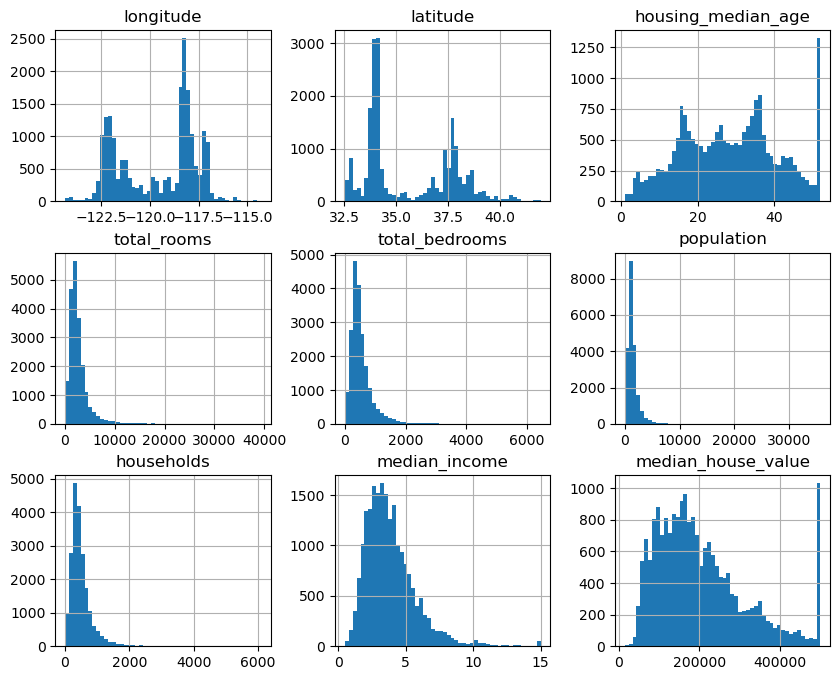

In [28]:
# histograms for the numeric features

housing.hist(bins=50, figsize=(10, 8)) 

plt.show()

# Observations from histograms
- After checking with the team that collected the data, we find that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in machine learning, and it is not necessarily a problem, but you should try to understand how the data was computed.
- The housing median age and the median house value are also capped. The latter may be a serious problem since it is our target feature. Our machine learning algorithms may learn that prices never go beyond that limit. 
- The features have very different scales. Points to need for feature scaling.
- Finally, many histograms are skewed right: they extend much farther to the right of the median than to the left. Some are multimodal. This may make it a bit harder for some machine learning algorithms to detect patterns. Later, we will be transforming these features to have more symmetrical and bell-shaped distributions.

# Create a test set
- pull out 20% of the data for testing the model. We take them out now to prevent data snooping bias.
    - random split 
    - stratified split on median_hoouse_value 

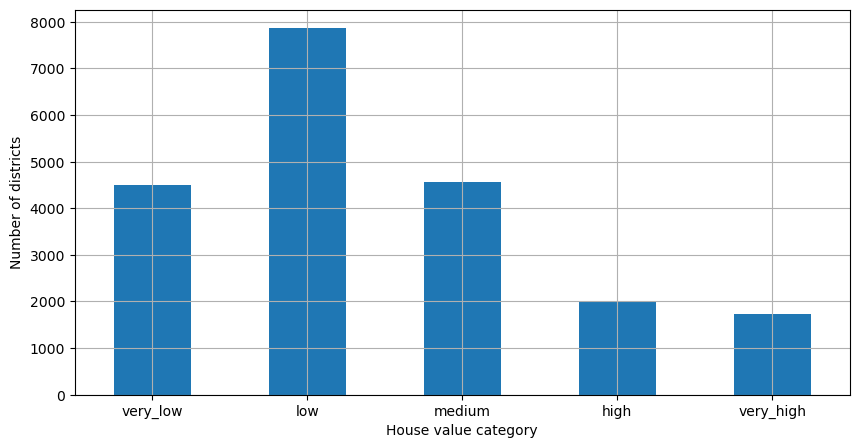

In [29]:
# from sklearn.model_selection import train_test_split

# this creates a random 80/20 split of the data into train and test set
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

# # a better approach is to get a representative sample across the median_house_value spectrum
from sklearn.model_selection import train_test_split

# this creates a random 80/20 split of the data into train and test set
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# a better approach is to get a representative sample across the median_house_value

housing["house_cat"] = pd.cut(housing["median_house_value"], bins=5, 
                              labels=["very_low", "low", "medium", "high", "very_high"])

housing["house_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True) 
plt.xlabel("House value category")
plt.ylabel("Number of districts")
plt.show()

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_train_set, strat_test_set = train_test_split(
housing, test_size=0.2, stratify=housing["house_cat"], random_state=71)

In [31]:
 strat_test_set["house_cat"].value_counts() / len(strat_test_set)

house_cat
low          0.381298
medium       0.221415
very_low     0.217539
high         0.096415
very_high    0.083333
Name: count, dtype: float64

In [32]:
# this creates a random 80/20 split of the data into train and test set
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

test_set["house_cat"].value_counts() / len(test_set)

house_cat
low          0.374758
very_low     0.218266
medium       0.213905
high         0.104167
very_high    0.088905
Name: count, dtype: float64

In [33]:
# drop the house_cat column; we will not be using it!
for set_ in (strat_train_set, strat_test_set): 
    set_.drop("house_cat", axis=1, inplace=True)

In [34]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14429,-117.25,32.94,15.0,1804.0,339.0,673.0,296.0,5.9806,370500.0,NEAR OCEAN
6584,-117.99,33.72,17.0,2801.0,649.0,1473.0,535.0,4.2875,134800.0,<1H OCEAN
7420,-121.88,39.74,12.0,14631.0,3298.0,7517.0,3262.0,1.6785,153100.0,INLAND
13732,-117.82,33.68,4.0,1346.0,213.0,603.0,219.0,8.7974,360600.0,<1H OCEAN
9877,-118.11,33.75,15.0,2569.0,812.0,785.0,477.0,5.4011,346400.0,NEAR OCEAN


# Exploring the training set to gain modeling insights
- first make a copy of the training data

In [35]:
thousing = strat_train_set.copy()

# Geographic visualization of the dataset

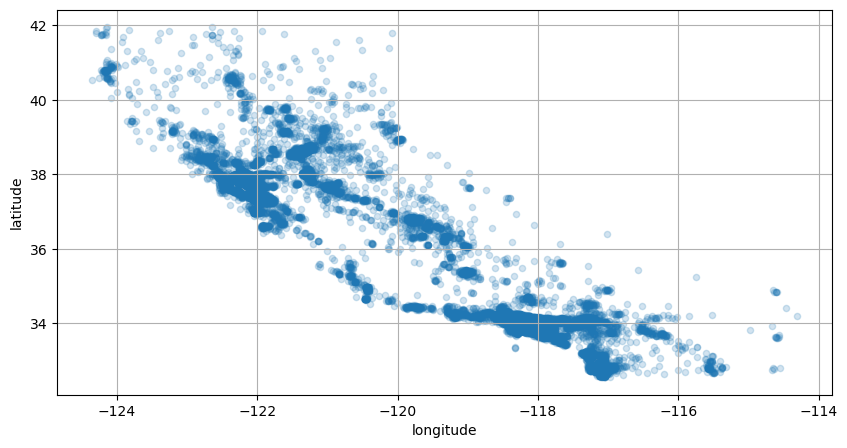

In [36]:
# alph a= 0.2 allows us to visualize places where there is a high density of points

thousing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2) 
plt.show()

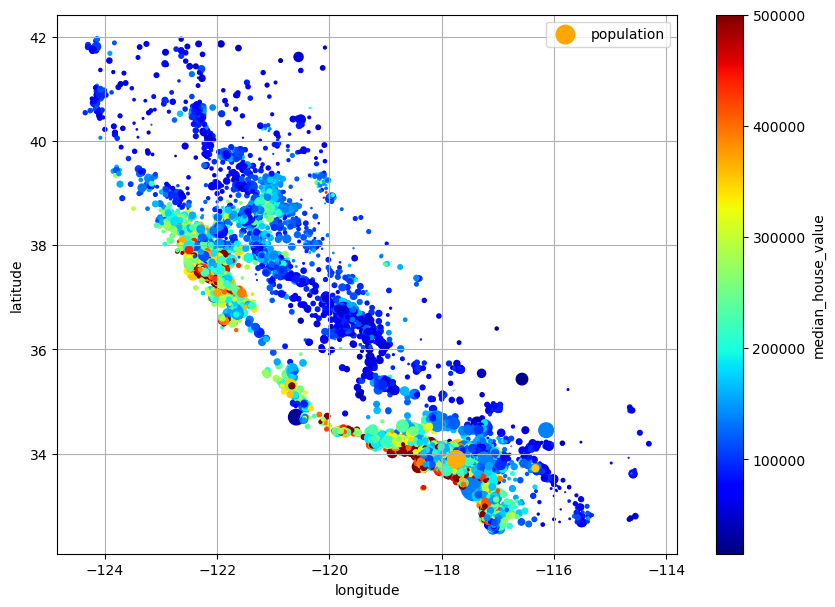

In [37]:
# plot the data to show population (dot size) and median house price (as hue)

thousing.plot(kind="scatter", x="longitude", y="latitude", grid=True, 
              s=thousing["population"] / 100, label="population", 
              c="median_house_value", cmap="jet", colorbar=True, 
              legend=True, sharex=False, figsize=(10, 7))
plt.show()

The radius of each circle represents the district’s population (option s), and the color represents the
price (option c). Here you use a predefined color map (option cmap) called
jet. 

This image tells us that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density. A clustering algorithm should be useful for detecting the main cluster and for adding new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

# An even better geographic visualization

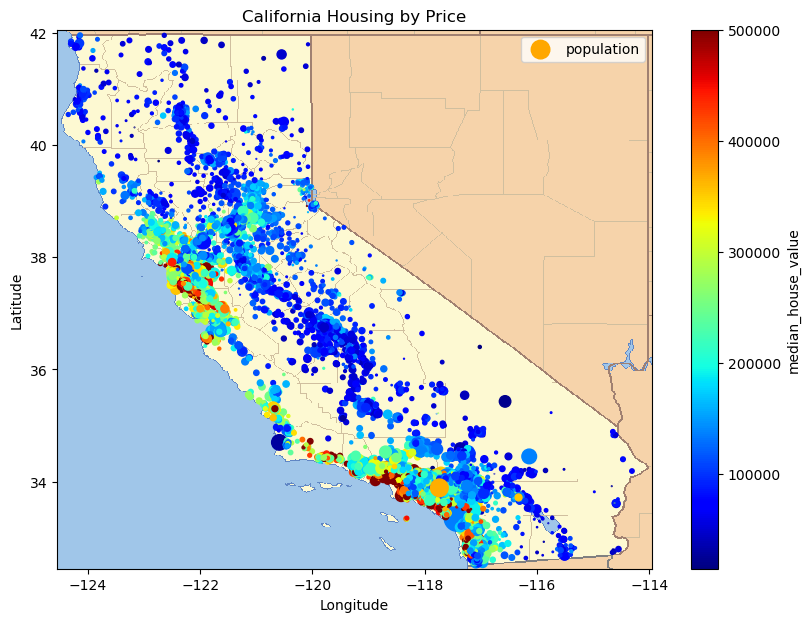

In [38]:
# Visualising house price vs lat/long against the map of California

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)


thousing.plot(
             kind="scatter", x="longitude", y="latitude",
             s=thousing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("California Housing by Price")
plt.show()

# Correlation Analysis
- we compute the standard correlation coefficient (Pearson's r) between every pair of features in our dataset.

In [39]:
thousing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [40]:
corr_matrix = thousing.corr(numeric_only=True)
plt.imshow(corr_matrix)
plt.xticks(ticks = range(thousing.shape[1]-1),labels=thousing.columns[:-1],rotation=90);
plt.yticks(ticks = range(thousing.shape[1]-1),labels=thousing.columns[:-1],rotation=0);
plt.colorbar()


The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north). Finally, coefficients close to 0 mean that there is no linear correlation.

In [41]:
# which features are best correlated with median_house_value?

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689229
total_rooms           0.136899
housing_median_age    0.103782
households            0.068002
total_bedrooms        0.051751
population           -0.024303
longitude            -0.046894
latitude             -0.141013
Name: median_house_value, dtype: float64

In [42]:
# plot house value against median income (the highest correlated feature)2
thousing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.2, grid=True);

This plot reveals a few things. First, the correlation is indeed quite strong; we can clearly see the upward trend, and the points are not too dispersed. Second, the price cap we noticed earlier is clearly visible as a horizontal line at $\$500,000$. But the plot also reveals other less obvious straight lines: a horizontal line around $\$450,000$, another around $\$350,000$, perhaps one around $\$280,000$, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

# Feature Engineering
- The total number of rooms in a district is not very useful if one doesn't know how many households there are. What we really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: we probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at.

In [43]:
thousing_copy = thousing.copy()

In [44]:
thousing_copy["rooms_per_house"] = thousing_copy["total_rooms"] / thousing_copy["households"] 
thousing_copy["bedrooms_ratio"] = thousing_copy["total_bedrooms"] / thousing_copy["total_rooms"] 
thousing_copy["people_per_house"] = thousing_copy["population"] / thousing_copy["households"]

In [45]:
# look at the correlations again

corr_matrix = thousing_copy.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689229
rooms_per_house       0.152436
total_rooms           0.136899
housing_median_age    0.103782
households            0.068002
total_bedrooms        0.051751
people_per_house     -0.022347
population           -0.024303
longitude            -0.046894
latitude             -0.141013
bedrooms_ratio       -0.255288
Name: median_house_value, dtype: float64

The new bedrooms_ratio attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

# Prepare data for ML algorithms: Part 1
- handle missing values
- represent categorical features as numerical vectors


In [46]:
# create fresh copies of the predictor matrix and the outcome variable

thousing_X = strat_train_set.drop("median_house_value",axis = 1)
thousing_y = strat_train_set["median_house_value"].copy()

In [47]:
null_rows_idx = thousing_X.isnull().any(axis=1) # Locate rows with null vaues
display(thousing_X.loc[null_rows_idx])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
2514,-122.38,37.73,40.0,543.0,NaN,259.0,89.0,2.2167,NEAR BAY
13862,-117.34,33.94,13.0,7910.0,NaN,3382.0,1176.0,5.5563,INLAND
16075,-116.91,32.83,16.0,5203.0,NaN,2515.0,862.0,4.1050,<1H OCEAN
12188,-121.02,37.48,26.0,467.0,NaN,244.0,83.0,4.1346,INLAND
477,-117.99,34.14,30.0,2346.0,NaN,1988.0,474.0,2.5625,INLAND
...,...,...,...,...,...,...,...,...,...
18751,-121.95,38.03,5.0,5526.0,NaN,3207.0,1012.0,4.0767,INLAND
4063,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,INLAND
19137,-118.53,34.26,18.0,3674.0,NaN,1590.0,550.0,8.1760,<1H OCEAN
12419,-119.38,36.53,38.0,1281.0,NaN,1423.0,293.0,1.9602,INLAND


In [48]:
# There are 168 rows with no data on total_bedrooms.
# We will use a simple median imputer to fill in any missing values in the numerical features of this dataset

from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy="median")

# select the numeric features in the predictor matrix
thousing_Xnum = thousing_X.select_dtypes(include=[np.number])

# compute the medians of the columns
imputer.fit(thousing_Xnum)

# transform the matrix by filling in median values of the column for missing values
X = imputer.transform(thousing_Xnum)

# convert the transformed matrix back into a dataframe
thousing_tr_num = pd.DataFrame(X, columns=thousing_Xnum.columns, index=thousing_Xnum.index)
thousing_tr_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14429,-117.25,32.94,15.0,1804.0,339.0,673.0,296.0,5.9806
6584,-117.99,33.72,17.0,2801.0,649.0,1473.0,535.0,4.2875
7420,-121.88,39.74,12.0,14631.0,3298.0,7517.0,3262.0,1.6785
13732,-117.82,33.68,4.0,1346.0,213.0,603.0,219.0,8.7974
9877,-118.11,33.75,15.0,2569.0,812.0,785.0,477.0,5.4011


In [49]:
# one hot code ocean proximity

thousing_cat = thousing[["ocean_proximity"]]

from sklearn.preprocessing import OneHotEncoder 

cat_encoder = OneHotEncoder(sparse_output=False)
thousing_cat_1hot = cat_encoder.fit_transform(thousing_cat)

thousing_tr_cat = pd.DataFrame(thousing_cat_1hot,columns=cat_encoder.get_feature_names_out())
thousing_tr_cat

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
16507,1.0,0.0,0.0,0.0,0.0
16508,1.0,0.0,0.0,0.0,0.0
16509,0.0,1.0,0.0,0.0,0.0
16510,1.0,0.0,0.0,0.0,0.0


# Prepare data for ML algorithms: Part 2
- feature scaling
    - With few exceptions, machine learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Without any scaling, most models will be biased toward ignoring the median income and focusing more on the number of rooms
- feature transformations via Radial Basis Function Kernels
   - When a feature’s distribution has a heavy tail (i.e., when values far from the mean are not exponentially rare), both min-max scaling and standardization will squash most values into a small range. Machine learning models generally don’t like this at all. So before you scale the feature, you should first transform it to shrink the heavy tail, and if possible to make the distribution roughly symmetrical. For example, a common way to do this for positive features with a heavy tail to the right is to replace the feature with its square root (or raise the feature to a power between 0 and 1). If the feature has a really long and heavy tail, such as a power law distribution, then replacing the feature with its logarithm may help. Another approach to transforming multimodal distributions is to add a feature for each of the modes (at least the main ones), representing the similarity between the housing median age and that particular mode. The similarity measure is typically computed using a radial basis function (RBF)—any function that depends only on the distance between the input value and a fixed point. The most commonly used RBF is the Gaussian RBF, whose output value decays exponentially as the input value moves away from the fixed point. 

## Minmax scaling

For each attribute, the values are shifted and rescaled so that they end up ranging from 0 to 1. 
This is performed by subtracting the min value and dividing by the difference between the min and the max.


In [50]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1)) 
thousing_tr_num_min_max_scaled = min_max_scaler.fit_transform(thousing_tr_num)
thousing_tr_num_min_max_scaled

array([[ 0.41434263, -0.91702128, -0.45098039, ..., -0.96244289,
        -0.88627602, -0.24405181],
       [ 0.26693227, -0.75106383, -0.37254902, ..., -0.91759859,
        -0.79414032, -0.47757962],
       [-0.50796813,  0.52978723, -0.56862745, ..., -0.57879985,
         0.25713184, -0.83743673],
       ...,
       [ 0.24900398, -0.57234043, -0.49019608, ..., -0.84063455,
        -0.68272938, -0.43978704],
       [-0.53984064,  0.0212766 ,  0.05882353, ..., -0.92572662,
        -0.81804163, -0.03822016],
       [-0.09163347, -0.10638298,  0.25490196, ..., -0.80229267,
        -0.67424827, -0.91405636]])

## Standardization 
is different: first it subtracts the mean value (so standardized values have a zero mean), 
then it divides the result by the standard deviation 
(so standardized values have a standard deviation equal to 1). 
Unlike min- max scaling, standardization does not restrict values to a specific range. 
However, standardization is much less affected by outliers.


In [51]:
from sklearn.preprocessing import StandardScaler 

std_scaler = StandardScaler()
thousing_tr_num_std_scaled = std_scaler.fit_transform(thousing_tr_num)
thousing_tr_num_std_scaled

array([[ 1.15968473, -1.26076969, -1.0869902 , ..., -0.67130189,
        -0.53560473,  1.10908377],
       [ 0.78986108, -0.89490794, -0.92766217, ...,  0.04191533,
         0.092718  ,  0.21867017],
       [-1.15421193,  1.92879428, -1.32598224, ...,  5.43027143,
         7.26190668, -1.1534219 ],
       ...,
       [ 0.74488252, -0.50090297, -1.16665421, ...,  1.26597439,
         0.852489  ,  0.36276876],
       [-1.2341738 ,  0.80775636, -0.05135801, ..., -0.08735529,
        -0.07027786,  1.89389519],
       [-0.10970998,  0.52632424,  0.34696206, ...,  1.87577511,
         0.91032624, -1.44556339]])

# Log transform
If the feature has a really long and heavy tail, such as a power law distribution, then replacing the feature with its logarithm may help. For example, the population feature roughly follows a power law: districts with 10,000 inhabitants are only 10 times less frequent than districts
with 1,000 inhabitants, not exponentially less frequent. The plots shows how much better this feature looks when you compute its log: it’s very close to a Gaussian distribution (i.e., bell-shaped).

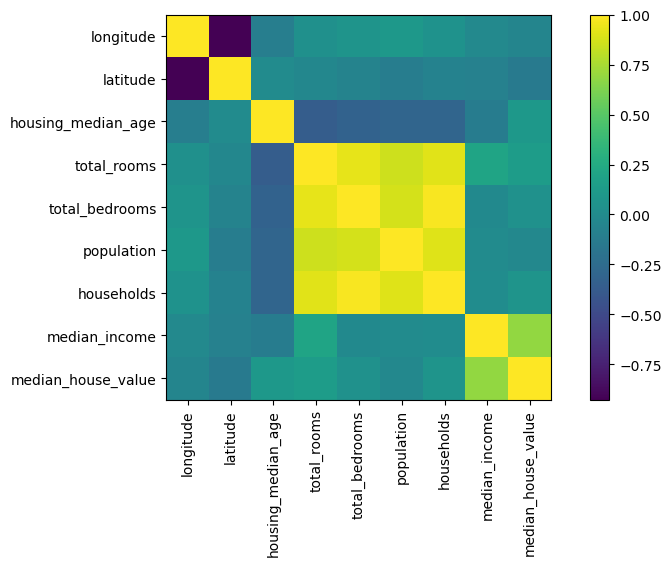

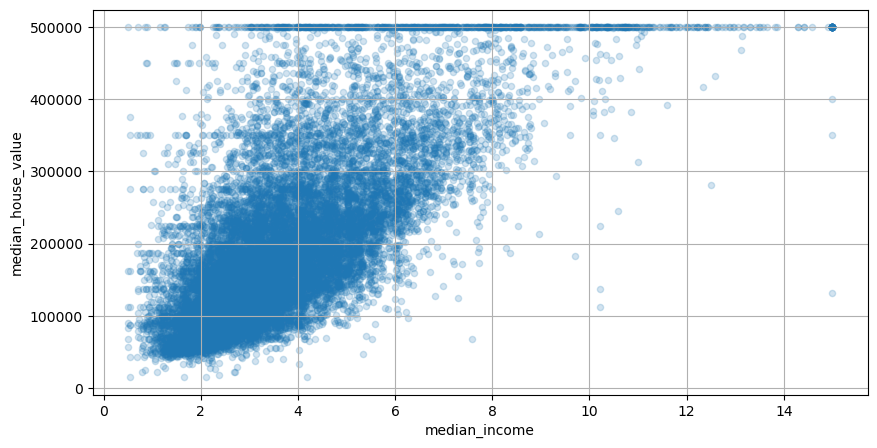

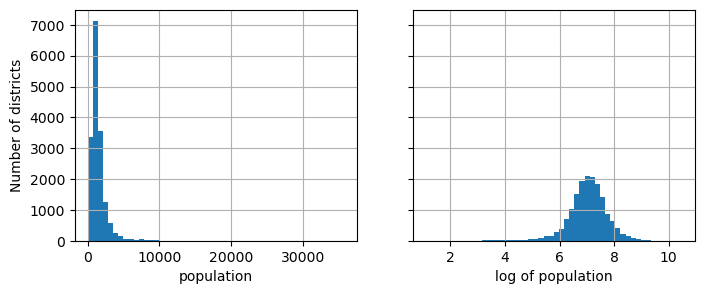

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
thousing_X["population"].hist(ax=axs[0], bins=50)
thousing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("population")
axs[1].set_xlabel("log of population")
axs[0].set_ylabel("Number of districts")

plt.show()

## Similarity based representations
Another approach to transforming multimodal distributions, such as median housing age,is to add a feature for each of the modes (at least the main ones), representing the similarity between the housing median age and that particular mode. The similarity measure is typically computed using a radial basis function (RBF) — a function that depends only on the distance between the input value and a fixed point. The most commonly used RBF is the Gaussian RBF, whose output value decays exponentially as the input value moves away from the fixed point. For example, the Gaussian RBF similarity between the housing age x and 35 is given by the equation exp(–γ(x – 35)2). The hyperparameter γ (gamma) determines how quickly the similarity measure decays as x moves away from 35. Using Scikit-Learn’s rbf_kernel() function, we can create a new Gaussian RBF feature measuring the similarity between the housing median age and 35:

In [53]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(thousing_X[["housing_median_age"]], [[35]], gamma=0.1)

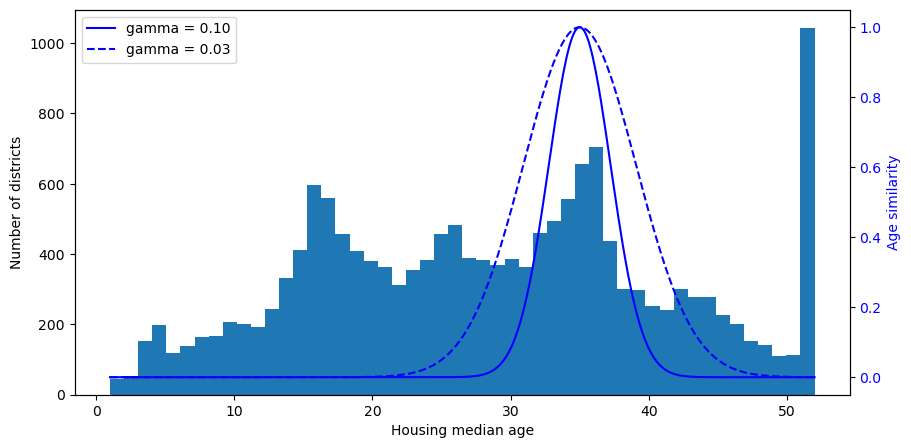

In [54]:
ages = np.linspace(thousing_X["housing_median_age"].min(),
                   thousing_X["housing_median_age"].max(),
                   500).reshape(-1, 1)

# Visualise different gamma values

gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(thousing_X["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

## Designing custom feature transformers
- function transformer (such as log)
- RBF transformer: for housing_age
- geographic similarity transformer: replacing (lat,long) by similarity or closeness to 10 population centeres determined by k-means clustering
- ratio transformers

In [55]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(thousing_X[["population"]])

In [56]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [57]:
 ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])

In [187]:
# Cluster similarity code - a sneak peak

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [188]:
# Creating clusters to identify  peak population centers in CA
# Can vary the number of clusters

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
latlong_similarities = cluster_simil.fit_transform(thousing_X[["latitude", "longitude"]],
                                           sample_weight=thousing_X["population"])

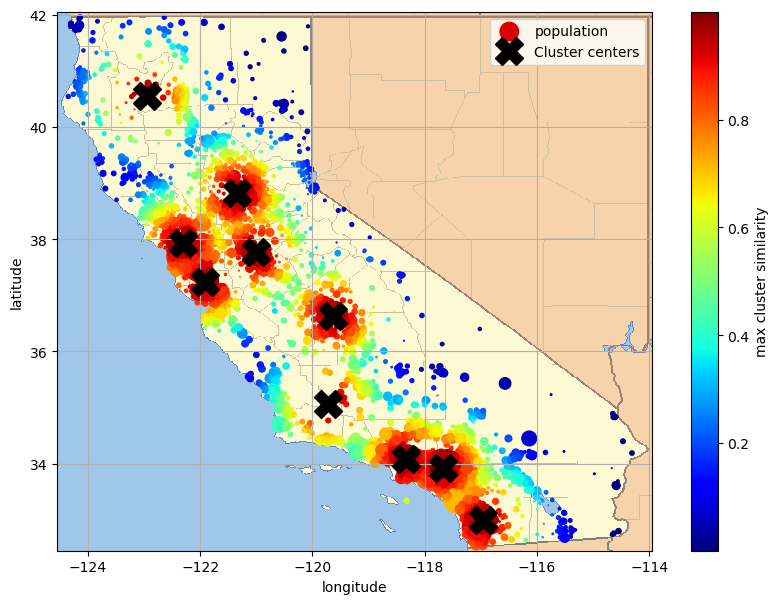

In [189]:
# Plotting similarity

tmp_df = thousing_X.copy()
tmp_df["max cluster similarity"] = latlong_similarities.max(axis=1)

tmp_df.plot(kind="scatter", x="longitude", y="latitude", grid=True,
                     s=tmp_df["population"] / 100, label="population",
                     c="max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")


california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()

# Transformation pipelines

As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations.

- In modeling, representation of predictors is everything! Good representations allow for simpler and more explainable models.
- In this section, we show you how to set up a transformation pipeline to transform the raw predictors into a more useful form for model building.

In [190]:
# Additional function to help patch predictoor variable names in a pipeline

def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

## A simple transformation pipeline

In [191]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))



num_features = ["longitude", "latitude", "housing_median_age", "total_rooms", 
                "total_bedrooms", "population", "households", "median_income"]
cat_features = ["ocean_proximity"]

preprocessing = ColumnTransformer([ ("num", num_pipeline, num_features), 
                                   ("cat", cat_pipeline, cat_features) ])

# this pipeline fills missing values and standardizes numeric features, fills in missing values for 
# categorical features and one-hot encodes them.

thousing_X_tmp = preprocessing.fit_transform(thousing_X)

thousing_X_tmp = pd.DataFrame(thousing_X_tmp,columns=preprocessing.get_feature_names_out())
thousing_X_tmp.head()

,num__longitude,num__latitude,num__housing_median_age,num__total_rooms,num__total_bedrooms,num__population,num__households,num__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
0,1.159685,-1.260770,-1.086990,-0.384142,-0.474247,-0.671302,-0.535605,1.109084,0.0,0.0,0.0,0.0,1.0
1,0.789861,-0.894908,-0.927662,0.075760,0.268237,0.041915,0.092718,0.218670,1.0,0.0,0.0,0.0,0.0
2,-1.154212,1.928794,-1.325982,5.532771,6.612875,5.430271,7.261907,-1.153422,0.0,1.0,0.0,0.0,0.0
3,0.874821,-0.913670,-1.963294,-0.595411,-0.776030,-0.733708,-0.738035,2.590459,1.0,0.0,0.0,0.0,0.0
4,0.729890,-0.880836,-1.086990,-0.031258,0.658639,-0.571451,-0.059762,0.804321,0.0,0.0,0.0,0.0,1.0


# Extending the transformation pipeline 
- add ratio features (bedrooms_ratio, rooms_per_house, people_per_house)
- add cluster similarity features to encode latitude/longitude
- replace features with long tails by logarithms

In [192]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

# put it all together!

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

# now transform thousing_X using this preprocessing pipeline

thousing_X_prep = preprocessing.fit_transform(thousing_X)

thousing_X_prep = pd.DataFrame(thousing_X_prep,columns=preprocessing.get_feature_names_out())
print(thousing_X_prep.shape)
thousing_X_prep.head()

(16512, 24)


,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
0,-0.414940,0.259940,-0.071047,-0.309200,-0.176127,-0.694606,-0.397707,1.155572,5.348158e-09,1.307966e-01,...,9.203936e-05,5.111521e-17,2.940168e-18,3.245052e-01,0.0,0.0,0.0,0.0,1.0,-1.086990
1,0.295383,-0.077428,-0.029187,0.578894,0.409012,0.364217,0.409001,0.448319,1.702631e-05,8.830523e-01,...,1.921566e-02,7.888646e-12,7.690136e-13,5.901249e-01,1.0,0.0,0.0,0.0,0.0,-0.927662
2,0.193326,-0.372049,-0.068362,2.801941,2.607645,2.567353,2.872884,-1.544561,3.245656e-07,6.676171e-21,...,2.615663e-13,1.005814e-02,1.918581e-03,4.475950e-24,0.0,1.0,0.0,0.0,0.0,-1.325982
3,-0.896236,0.280174,-0.029173,-0.944684,-0.565629,-0.843064,-0.808331,1.975704,7.545290e-06,7.789545e-01,...,9.769363e-03,1.989770e-12,1.475421e-13,7.031525e-01,1.0,0.0,0.0,0.0,0.0,-1.963294
4,1.664099,-0.018431,-0.125853,0.885304,0.294025,-0.486523,0.252608,0.938990,2.944715e-05,9.308396e-01,...,2.997632e-02,2.039387e-11,2.406932e-12,5.031003e-01,0.0,0.0,0.0,0.0,1.0,-1.086990


# Model building with PyTorch (10 points)

- create the linear regression PyTorch model (Read 3.5.1 d2l.ai) (4 points)
   - define the network structure
   - set the learning rate lr, and number of inputs num_inputs
   - use nn.Linear with num_inputs inputs and one output to set up self.net
   - initialize the weights of network to numbers drawn from a zero-mean normal distribution with std = noise (use self.net.weight.data.normal_(mean,std))
   - initialize bias weight to 0 (use self.net.bias.data.fill_(val))
- define the forward function (Read 3.5.1 d2l.ai) (2 points)
   - propagate the input X through the net
- define the loss function (mean squared error) (Read 3.5.2 d2l.ai) (2 points)
   - nn.functional.mse_loss
- configure the optimizer (Read 3.5.3 d2l.ai) (2 points)
   - use torch.optim.SGD() with self.parameters() and set learning to be the learning rate of the network

In [193]:
class RegressionModel(nn.Module):
    def __init__(self, num_inputs,  lr, noise=0.01):
        super(RegressionModel, self).__init__()
        # START YOUR CODE HERE (4 lines)
        self.num_inputs, self.lr = num_inputs, lr 
        self.net = nn.Linear(num_inputs, 1)
        self.net.weight.data.normal_(0, noise)
        self.net.bias.data.fill_(0)
        # END YOUR CODE HERE
        
    def forward(self, X):
        # START YOUR CODE HERE (1 line)
        return self.net(X)
        # END YOUR CODE HERE
    
    def loss(self,yhat,y):
        # START YOUR CODE HERE (1 line)
        return nn.functional.mse_loss(yhat, y)
        # END YOUR CODE HERE

    def configure_optimizers(self):
        # START YOUR CODE HERE (1 line)
        return torch.optim.SGD(self.parameters(), lr= self.lr)
        # END YOUR CODE HERE

# Test your model set up code
- run this code after completing the cell above.
- you should be able to view your model's structure and its weights and bias
- Note the input size may vary depending on the dataset

In [194]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegressionModel(thousing_X_prep.shape[1],0.1)
model = model.to(device)
print(model)

# access model's weights and bias
print(model.net.weight)
print(model.net.bias)

# Visualise your model
summary(model, input_size=(thousing_X_prep.shape[1],))

RegressionModel(
  (net): Linear(in_features=24, out_features=1, bias=True)
)
Parameter containing:
tensor([[ 1.9719e-05, -6.3687e-03, -1.4969e-02,  1.5055e-02, -5.5970e-03,
         -9.7207e-03, -6.8847e-03, -8.5118e-03,  9.9854e-03, -9.6849e-03,
          1.3922e-02, -7.1742e-03,  6.3583e-03, -1.0799e-02,  2.6312e-03,
         -7.4833e-03,  1.0399e-02, -1.2957e-02, -2.3621e-03, -4.8307e-03,
         -1.7780e-03, -3.3649e-03, -5.4248e-03,  1.9038e-03]],
       requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]              25
Total params: 25
Trainable params: 25
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
------------------------

In [195]:
# takes in a numpy array a and returns a torch tensor of type float32

def make_tensor(a):
    return torch.tensor(a).to(torch.float32)

# Train the model (10 points)

The train function takes the X dataframe Xdf, the y series ys, an initialized model, and num_epochs, as inputs. It produces the trained model as output.

Here we will write out the training loop explicitly to be able to understand the steps in the training process. 


- Split the Xdf and y series to a training and validation set using train_test_split in the 80/20 ratio
- Convert the Xtrain, Xval, ytrain, yval into tensors using the make_tensor function

-  Set up the model by instantiating RegressionModel with the number of columns in Xtrain_tensor, and learning rate lr

-  Configure the optimizer for the model by calling the configure_optimizers() method defined in the RegressionModel class.
- Initialize torch tensors of length num_epochs to store train set loss and val set loss (for plotting)
-  For epoch in range(num_epochs)
   - zero the parameter gradients in the optimizer (use zero_grad())
   - perform a forward pass, and calculate loss on train set (model.loss()). Store train set loss in train set loss tensor.
   - do a backward step to calculate gradients (loss.backward())
   - get the optimizer to take a step in direction of the gradient (optimizer.step())
   - calculate loss on val set and store in val set loss tensor
-  Plot train set loss and val set loss on y-axis and epoch number on x-axis. These are the training curves.
-  Return the regression model object

In [196]:
# takes in a numpy array a and returns a torch tensor of type float32

def make_tensor(a):
    return torch.tensor(a).to(torch.float32)

In [197]:
# X is predictor dataframe, y is the corresponding labels Series

def train_model(Xdf,ys,model,num_epochs):

    # START YOUR CODE HERE    
    # split Xdf, y into Xtrain,ytrain, Xval,yval in 80/20 ratio (1 line)
    Xtrain_df, Xval_df, ytrain_s, yval_s = train_test_split(Xdf, ys, test_size=0.2, random_state=42)
    
    # convert them to tensors (2-4 lines)
    Xtrain = make_tensor(Xtrain_df.values)        
    Xval   = make_tensor(Xval_df.values)           
    ytrain = make_tensor(ytrain_s.values[:, None])  # (N,1) 
    yval   = make_tensor(yval_s.values[:, None])    # (M,1)
     
    
    # configure optimizer for model (1 line)
    optimizer = model.configure_optimizers()

    # initialize train loss and val loss tensors for plotting (1-2 lines)
    train_loss = torch.zeros(num_epochs)
    val_loss   = torch.zeros(num_epochs)
    
    # loop over each epoch from 0 to num_epochs-1 (1 line)
    for epoch in range(num_epochs):

       # zero the parameter gradients (1 line)
       optimizer.zero_grad()

       # forward + backward + optimize step (4 lines)
       yhat_train = model(Xtrain)           
       loss_train = model.loss(yhat_train, ytrain)
       loss_train.backward()
       optimizer.step()

       # calculate and store train loss and val loss for the epoch (2 lines)
       train_loss[epoch] = loss_train
       val_loss[epoch]  = model.loss(model(Xval), yval)


     # END YOUR CODE HERE

    # plot train set loss and val set loss as a function of epoch
    plt.figure(figsize=(10,5))
    plt.plot(train_loss.detach().numpy(),label='train')
    plt.plot(val_loss.detach().numpy(),label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training curves')
    plt.legend()
    plt.show()

    # print values of train set loss and val set loss on the last epoch
    print('Train loss: ', train_loss[-1])
    print('Val loss: ', val_loss[-1])

    return model

# Run this cell after completing the cell above.

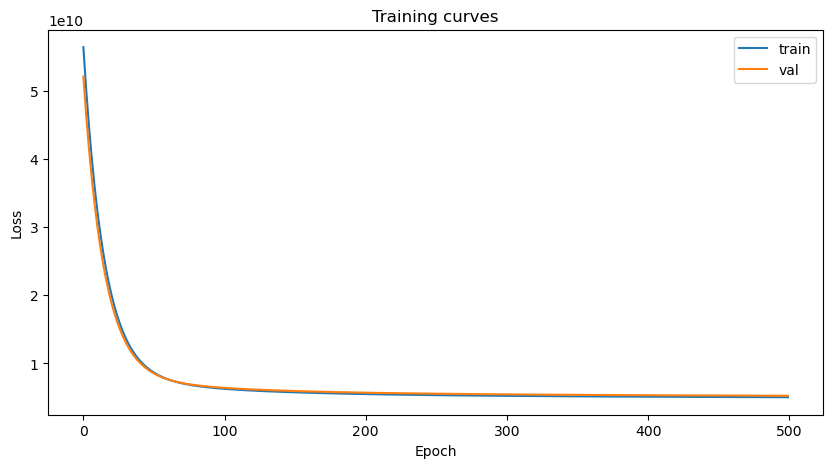

Train loss:  tensor(5.0486e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(5.2645e+09, grad_fn=<SelectBackward0>)


In [198]:
lr = 0.01
num_epochs = 500

# set up the RegressionMode object model with the appropriate parameters (1 line)
model = RegressionModel(thousing_X_prep.shape[1],lr=lr)

model = train_model(thousing_X_prep,thousing_y,model,num_epochs)

# Analyze model performance (10 points)
- break strat_test_set apart into strat_testX and strat_testy (isolating predictors and median_house_value) (1 point)
- preprocess strat_testX through the preprocessing pipeline to make strat_testX_prep (1 point)
- get histogram of errors (actual price - predicted price) on strat_testX_prep and  strat_testy (1 point)
- get scatterplot of actual price vs predicted price on strat_testX_prep (3 points)
- compute R2 of concordance between actual and predicted values using sklearn.metrics r2_score() function. (4 points)

R2: 0.5919677219568483


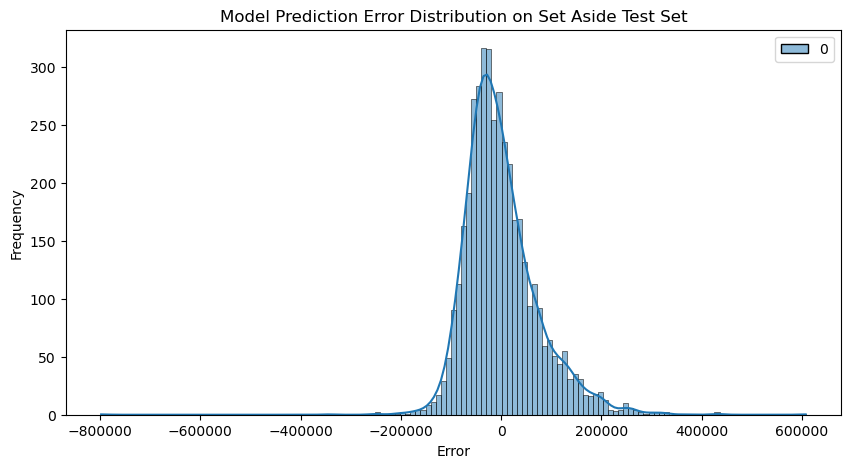

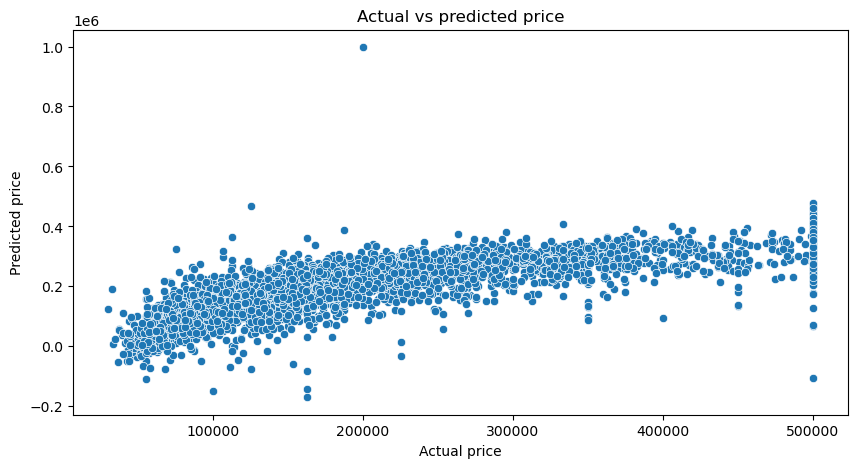

In [199]:
# START YOUR CODE HERE 

# get X and y components of strat_test_set (2 lines)
strat_testX = strat_test_set.drop("median_house_value", axis=1)
strat_testy = strat_test_set["median_house_value"]

# preprocess strat_testX by preprocessing pipeline (1 line) and convert the array into a dataframe
# use preprocessing.get_feature_names_out() to get the column names
strat_testX_prep = pd.DataFrame(preprocessing.transform(strat_testX), columns=preprocessing.get_feature_names_out())

# make test X and test y into tensors (2 lines)
# reshape testy tensor into shape (m,1)
testX_tensor = make_tensor(strat_testX_prep.values)
strat_testy_tensor = make_tensor(strat_testy.values[:, None])  # (m,1)

# compute prediction on testX and error (2 lines)
yhat = model(testX_tensor)
error = strat_testy_tensor - yhat  

# assess model quality using r2 (1 line)
r2 = r2_score(strat_testy.values, yhat.detach().numpy().reshape(-1)) # 1-D arrays
print("R2:", r2)
# END YOUR CODE HERE

# change the variable names as appropriate in the plot code below to reflect what you have above.

# plot error histogram
plt.figure(figsize=(10,5))
sns.histplot(error.detach().numpy(),kde=True)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Model Prediction Error Distribution on Set Aside Test Set')
plt.show()

# scatter plot of predicted vs actual price (4 lines)
plt.figure(figsize=(10,5))
sns.scatterplot(x=strat_testy_tensor.reshape(-1),y=yhat.detach().numpy().reshape(-1))
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual vs predicted price')
plt.show()



# Visualize model parameters
- run code in the following two cells

In [200]:
# Model parameters
print('Model weights:', model.net.weight)
print('Model bias:', model.net.bias)

Model weights: Parameter containing:
tensor([[ 13782.9951,   1792.3928,   1554.9315,  13741.3008,  18416.2910,
         -47399.9180,  16428.4805,  70101.7031,   -380.9300,  48928.2109,
          43910.6992,  11291.3896,    187.3991,   2532.3071,  19618.7480,
           7585.9556,  42158.5391,   9199.9707,  46041.3516,   -344.0318,
            330.3022,  30488.9512,  57930.3867,  11494.1309]],
       requires_grad=True)
Model bias: Parameter containing:
tensor([134446.9219], requires_grad=True)


C:\Users\veron\AppData\Local\Temp\ipykernel_10056\923654919.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


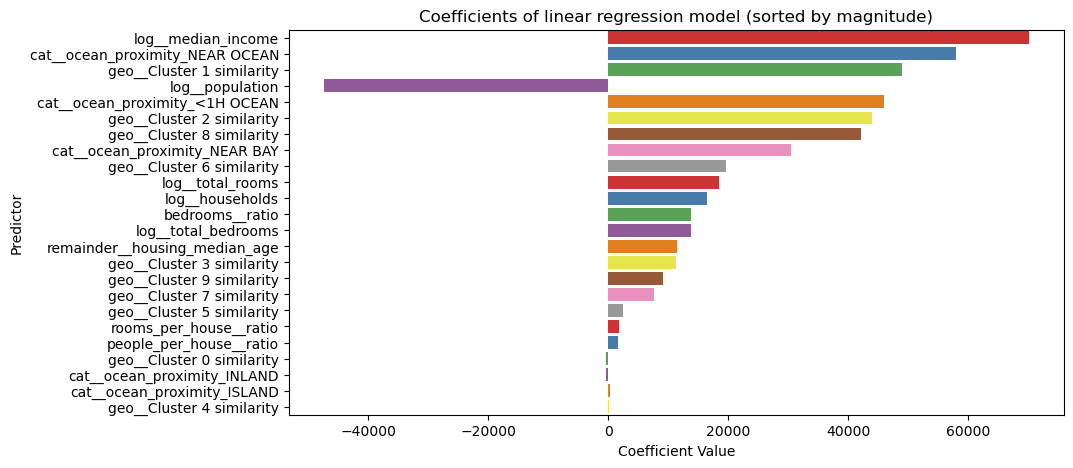

In [201]:
# plot model coefficients
coefs = pd.DataFrame(model.net.weight.data.detach().numpy(), columns=preprocessing.get_feature_names_out())
sorted_idx = coefs.iloc[0].abs().sort_values(ascending=False).index  # sort by absolute value
sorted_coefs = coefs[sorted_idx]
sns.barplot(
    y=sorted_coefs.columns,
    x=sorted_coefs.iloc[0].values, palette = 'Set1',
    orient='h'
)
plt.title('Coefficients of linear regression model (sorted by magnitude)')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictor')
plt.show()

In [202]:
# Save model
torch.save(model.state_dict(), 'simple_model.pth')

# To reload, use the following (uncomment the following line)
# model = torch.load('simple_model.pth') # reloading the model

# Cross-validation to assess model quality (10 points)

Up to now, we have assessed model quality with a single train/test split. Now we use a more systematic approach based on 5-fold crossvalidation.  The $R^2$ value is used as a measure of model quality. The closer $R^2$ is to 1., the better the model is.

The train_cv_model takes the training X dataframe Xdf and the corresponding y series, a set of K initialized models, the number of folds K for cross-validation, num_epochs and a boolean flag for plotting called plot_loss. When you do finetuning of the models later on in this notebook, it will be helful to turn the plotting off.

The function returns a list of K trained models and a list of K r2 scores (on the validation set for for each fold).


for (train_index, val_index) in kfolds.split(Xdf,ys):
- get model for fold i from models
- extract Xtrain,ytrain,Xval,yval using train_index and val_index from Xdf and ys
- convert Xtrain,ytrain,Xval,yval into tensors
- configure the optimizer for the model
- initialize train and val loss to 0
- train the model for num_epochs following the same steps as you did for the simple train_model function
- append the trained model to cv_models
- compute r2 score for trained model on the val set, and append to r2 scores




In [203]:
from sklearn.model_selection import  KFold


def train_cv_model(Xdf,ys,models,K,num_epochs,plot_loss=True):
    i = 0
    cv_models = []
    r2_scores = []
    
    kfolds = KFold(n_splits=K)

    # START YOUR CODE HERE
    X_np = Xdf.values
    y_np = ys.values
    
    # for each (train,val) split do
    for train_index, val_index in kfolds.split(Xdf, ys):
        # get the model for fold i (1 line)
        model = models[i]
        
        # separate into train and val set for the fold (2-4 lines)
        Xtrain_np, Xval_np = X_np[train_index], X_np[val_index]
        ytrain_np, yval_np = y_np[train_index], y_np[val_index]

        # make tensors (2-4 lines)
        Xtrain = make_tensor(Xtrain_np)
        Xval = make_tensor(Xval_np)
        ytrain = make_tensor(ytrain_np[:, None])
        yval = make_tensor(yval_np[:, None]) 
        
        # do the training loop for this fold
           # configure optimizer for model (1 line)
        optimizer = model.configure_optimizers()
        
           # initialize train loss and val loss tensors for plotting (1-2 lines)
        train_loss = torch.zeros(num_epochs)
        val_loss   = torch.zeros(num_epochs)
        
           # loop over each epoch from 0 to num_epochs-1 (1 line)
        for epoch in range(num_epochs):

             # zero the parameter gradients (1 line)
            optimizer.zero_grad()

            # forward + backward + optimize step (4 lines)
            yhat_train = model(Xtrain)
            loss_train = model.loss(yhat_train, ytrain)
            loss_train.backward()
            optimizer.step()

            # calculate and store train loss and val loss for the epoch (2 lines)
            train_loss[epoch] = loss_train
            val_loss[epoch]   = model.loss(model(Xval), yval)
            
        # append the model to the list cv_models (1 line)
        cv_models.append(model)

        # calculate r2 score of model[i] on val set for the fold and append to r2_scores (1-2 lines)
        r2 = r2_score(yval_np, model(Xval).detach().numpy().reshape(-1))
        r2_scores.append(r2)
        # END YOUR CODE HERE

        # plot train set loss and val set loss as a function of epoch
        if plot_loss:
            plt.figure(figsize=(10,5))
            plt.plot(train_loss.detach().numpy(),label='train')
            plt.plot(val_loss.detach().numpy(),label='val')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training curves for Fold ' + str(i))
            plt.legend()
            plt.show()
        
            # print values of train set loss and val set loss on the last epoch
            print('Train loss: ', train_loss[-1])
            print('Val loss: ', val_loss[-1])
        i = i + 1
    return cv_models, r2_scores


# Run the cell below after completing code in cell above.

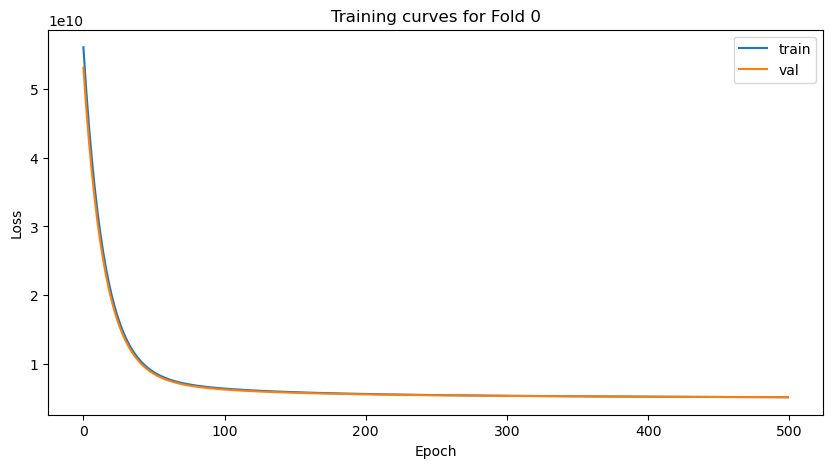

Train loss:  tensor(5.0961e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(5.0956e+09, grad_fn=<SelectBackward0>)


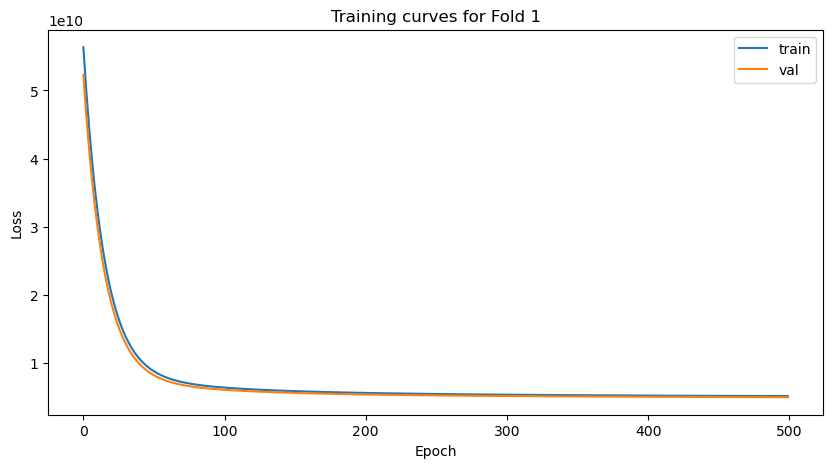

Train loss:  tensor(5.1165e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(4.9525e+09, grad_fn=<SelectBackward0>)


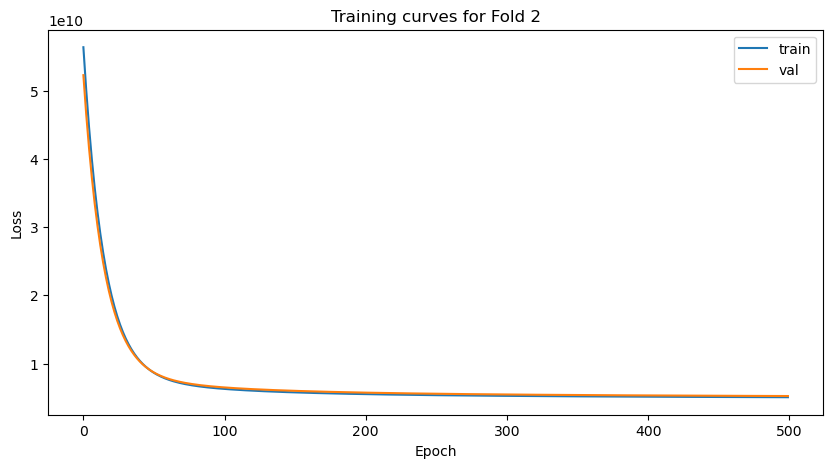

Train loss:  tensor(5.0618e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(5.2367e+09, grad_fn=<SelectBackward0>)


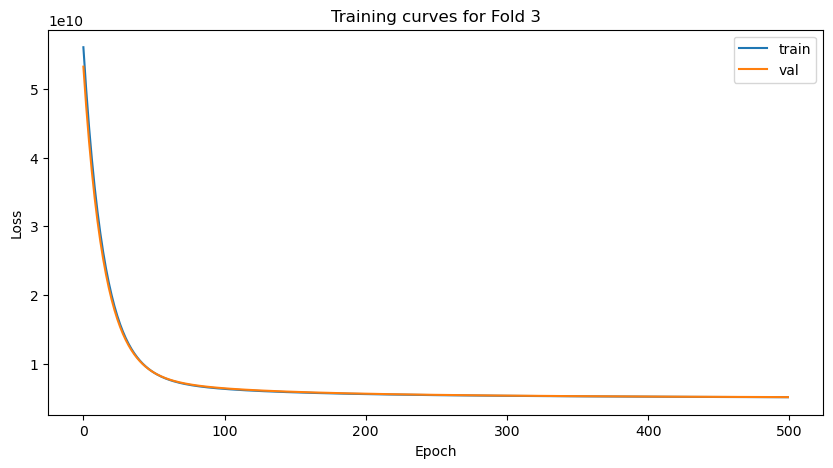

Train loss:  tensor(5.0875e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(5.1026e+09, grad_fn=<SelectBackward0>)


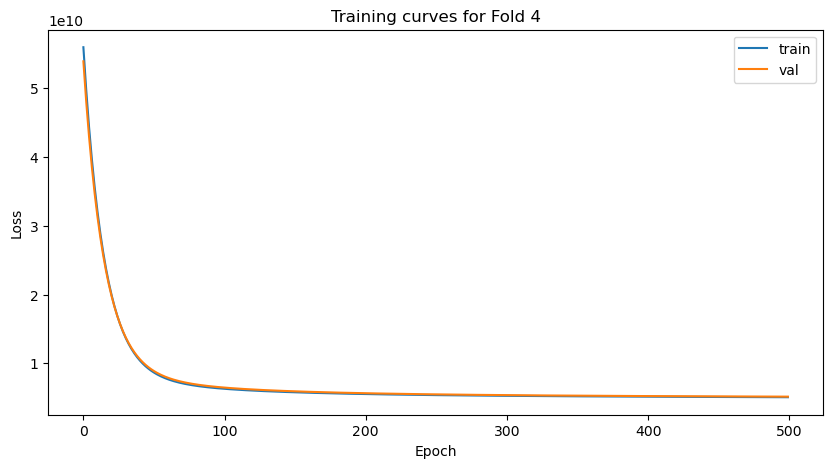

Train loss:  tensor(5.0760e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(5.1606e+09, grad_fn=<SelectBackward0>)
0.6168670120445675


In [204]:
lr = 0.01
num_epochs = 500
K = 5

kfolds = KFold(n_splits=K)
models = [RegressionModel(thousing_X_prep.shape[1],lr = lr) for _ in range(K)]

cv_models, r2_scores = train_cv_model(thousing_X_prep,thousing_y,models,K,num_epochs)

print(np.mean(r2_scores))

# Evaluate the CV models on set aside test set (5 points)
- compute r2 and mean-squared-error scores for the K CV models

In [143]:
r2_scores, mse_scores = [], []

# START YOUR CODE HERE
# loop over each model
# compute r2 and mse over the set aside test set (6 lines) 
y_true = strat_testy.values
for model in cv_models:
    y_pred = model(testX_tensor).detach().numpy().reshape(-1)
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2_scores.append(r2); mse_scores.append(mse)
    
# END YOUR CODE HERE   
print('Mean R2 = ', np.mean(r2_scores), 'Std R2 = ', np.std(r2_scores))
print('Mean MSE = ', np.mean(mse_scores), 'Std MSE = ', np.std(mse_scores))

Mean R2 =  0.592317616338738 Std R2 =  0.0008825131604027192
Mean MSE =  5385468090.772741 Std MSE =  11657963.786300864


# Visualize the CV model

- run this cell to view the coefficients of the K models

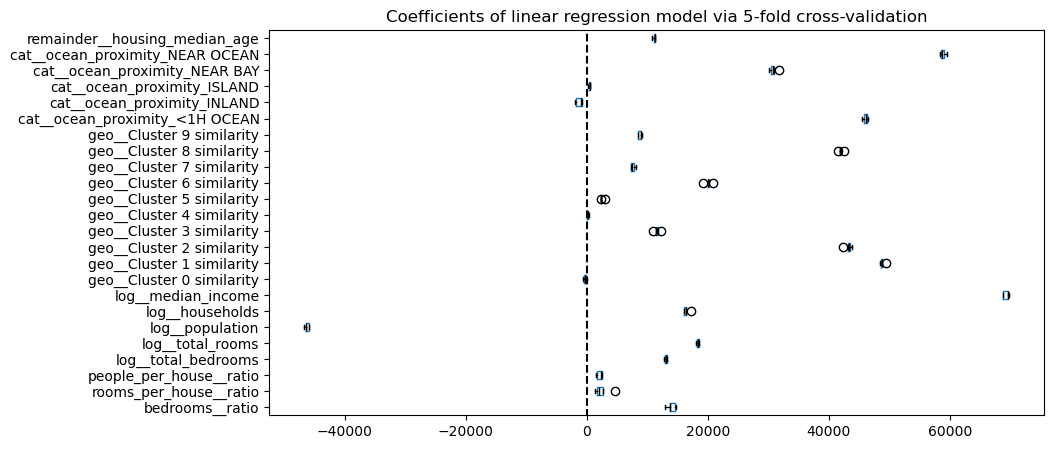

In [151]:
coefs = pd.DataFrame()
for i in range(K):
    coef = pd.DataFrame(cv_models[i].net.weight.data.detach().numpy(),columns=preprocessing.get_feature_names_out())
    coefs = pd.concat([coefs,coef],axis=0)
coefs = coefs.reset_index(drop=True)

color = {"whiskers": "black", "medians": "black", "caps": "black"}
coefs.plot.box(vert=False, color=color)
plt.axvline(x=0, ymin=-1, ymax=1, color="black", linestyle="--")
_ = plt.title("Coefficients of linear regression model via 5-fold cross-validation")
plt.show() # force display now so this figure isn’t redisplayed by other cells



## Adding L2 weight decay to regression model (5 points)

- define a new class RegressionModelL2 by copying the RegressionModel class and adding a new argument to the init function: wd (for weight decay or lambda)
- fill in the methods below
- you need to modify the torch.optim.SGD call to include weight_decay and the loss function to add the L2 penalty

In [225]:
class RegressionModelL2(nn.Module):
    def __init__(self, num_inputs,  lr, noise=0.01,wd=0.1):
        super(RegressionModelL2, self).__init__()
        # START YOUR CODE HERE (5-7 lines)
        self.num_inputs = num_inputs
        self.lr = lr
        self.wd = wd
        self.net = nn.Linear(num_inputs, 1)
        self.net.weight.data.normal_(0, noise)
        self.net.bias.data.fill_(0)
        # END YOUR CODE HERE
        
    def forward(self, X):
        # START YOUR CODE HERE (1 line)
        return self.net(X)
        # END YOUR CODE HERE
        
    def loss(self,yhat,y):
        # START YOUR CODE HERE (1 line)
        return nn.functional.mse_loss(yhat, y)
        # END YOUR CODE HERE

   
    def configure_optimizers(self):
        # START YOUR CODE HERE (1 line)
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)
        # END YOUR CODE HERE

# Set up L2 regression model and train using a simple train/val split (5 points)
- 5 points for completing and running the code below and assessing model quality as a function of the value of wd
- try different values of wd and see its impact on r2 as well as on the coefficient magnitudes and signs
- leave your experiments in the notebook for the grader to see. Add a Markdown cell to describe your observations on the impact of wd on the model

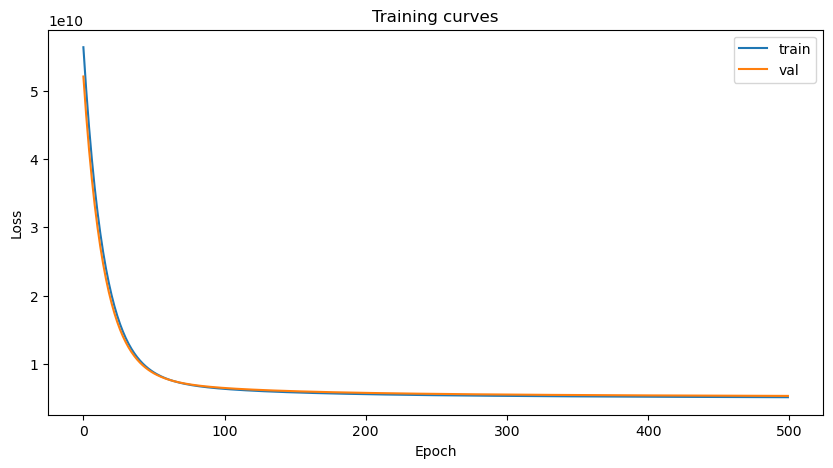

Train loss:  tensor(5.1000e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(5.2933e+09, grad_fn=<SelectBackward0>)
R2: 0.5923156046464922


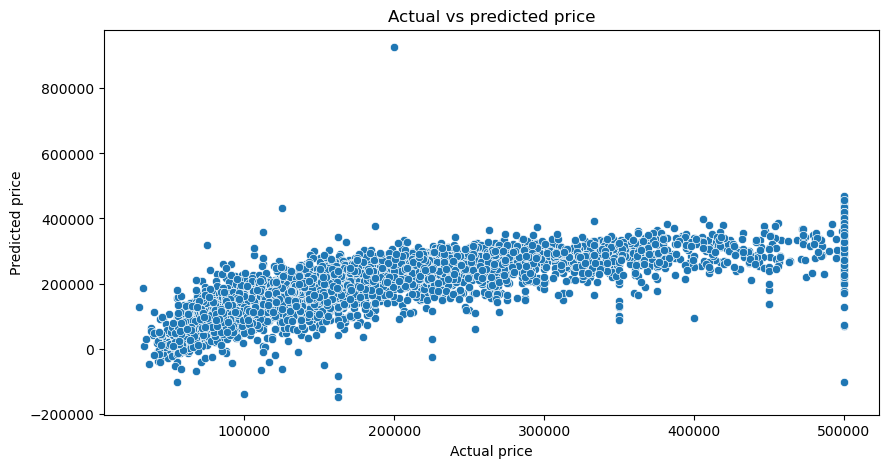

In [238]:
lr = 0.01
num_epochs = 500
wd = 0.05

l2_model = RegressionModelL2(thousing_X_prep.shape[1],lr=lr,wd=wd)

l2_model = train_model(thousing_X_prep,thousing_y,l2_model,num_epochs)

# START YOUR CODE HERE
# compute prediction on set aside test set and error. make sure you have preprocessed the test set 
# using the same pipeline as the train set (2 lines)
yhat  = l2_model(testX_tensor)
error = strat_testy_tensor - yhat

# assess model quality using r2 (1 line)
r2 = r2_score(strat_testy.values, yhat.detach().numpy().reshape(-1))
print("R2:", r2)
# END YOUR CODE HERE

# adjust variable names below to reflect the ones you are using
plt.figure(figsize=(10,5))
sns.scatterplot(x=strat_testy_tensor.reshape(-1).detach().numpy(),y=yhat.reshape(-1).detach().numpy())
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual vs predicted price')
plt.show()

# Visualize L2 model
- run the code below

C:\Users\veron\AppData\Local\Temp\ipykernel_10056\1869898119.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


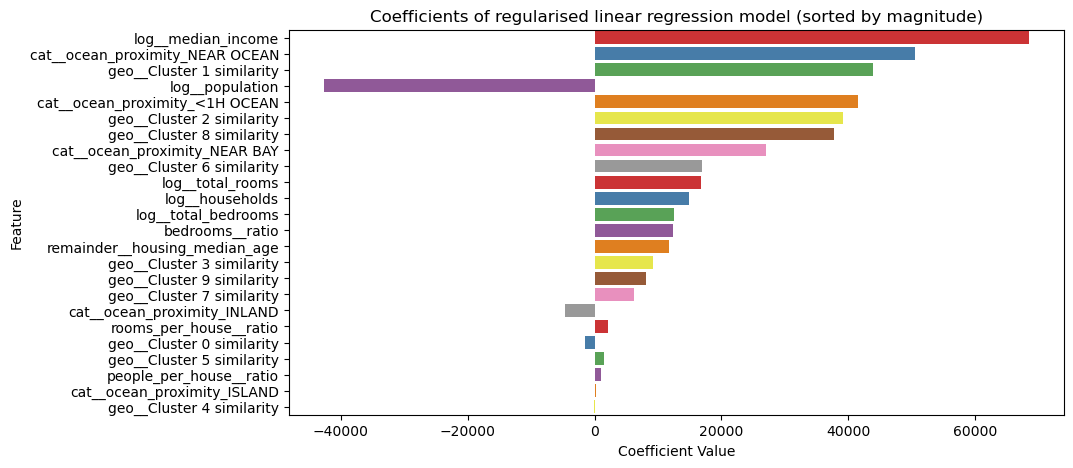

In [227]:
# plot model coefficients
coefs = pd.DataFrame(l2_model.net.weight.data.detach().numpy(), columns=preprocessing.get_feature_names_out())
sorted_idx = coefs.iloc[0].abs().sort_values(ascending=False).index  # sort by absolute value
sorted_coefs = coefs[sorted_idx]
sns.barplot(
    y=sorted_coefs.columns,
    x=sorted_coefs.iloc[0].values, palette='Set1',
    orient='h'
)
plt.title('Coefficients of regularised linear regression model (sorted by magnitude)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Try Other Weight Decay

- We notice that as we increase wd, the magnitude of coefficients decrease. This aligns with stronger L2 regularization: larger wd means heavier penalty on coefficients which implies smaller coefficients (more regularization). It also seems that as we increase wd, more coefficients become negative in magnitude. Finally, R^2 seems to be highest around wd = 0.05.


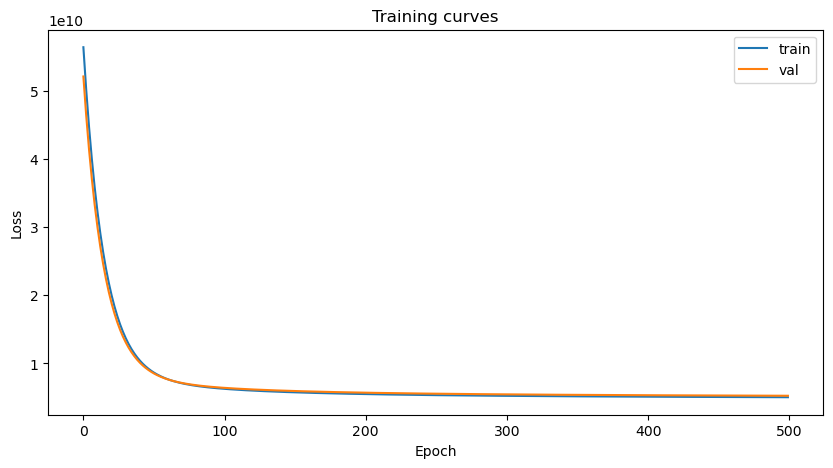

Train loss:  tensor(5.0495e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(5.2649e+09, grad_fn=<SelectBackward0>)
Weight Decay: 0.001
R2: 0.5919960558706012


C:\Users\veron\AppData\Local\Temp\ipykernel_10056\833491417.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


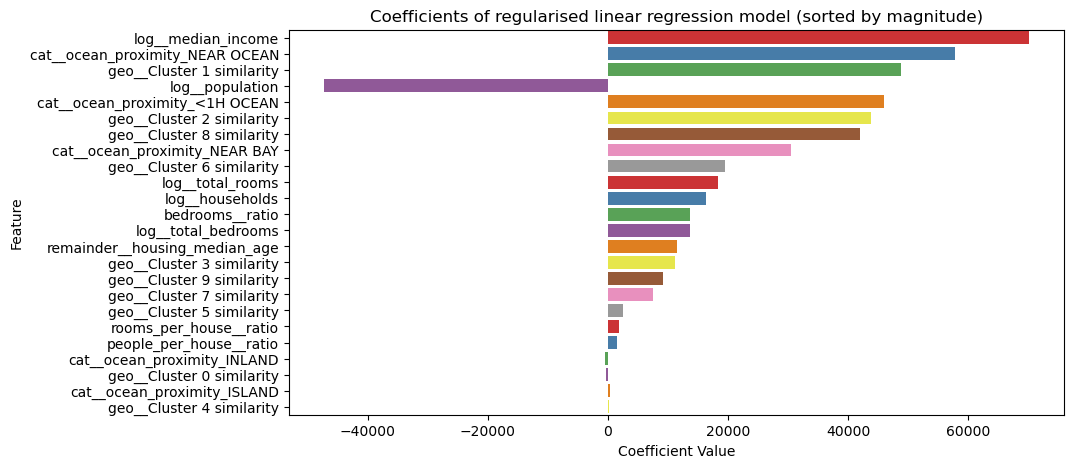

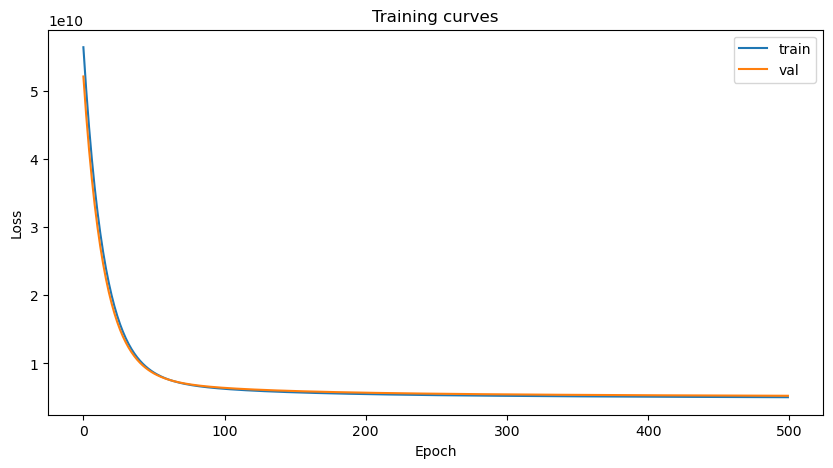

Train loss:  tensor(5.0529e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(5.2665e+09, grad_fn=<SelectBackward0>)
Weight Decay: 0.005
R2: 0.5920997613426355


C:\Users\veron\AppData\Local\Temp\ipykernel_10056\833491417.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


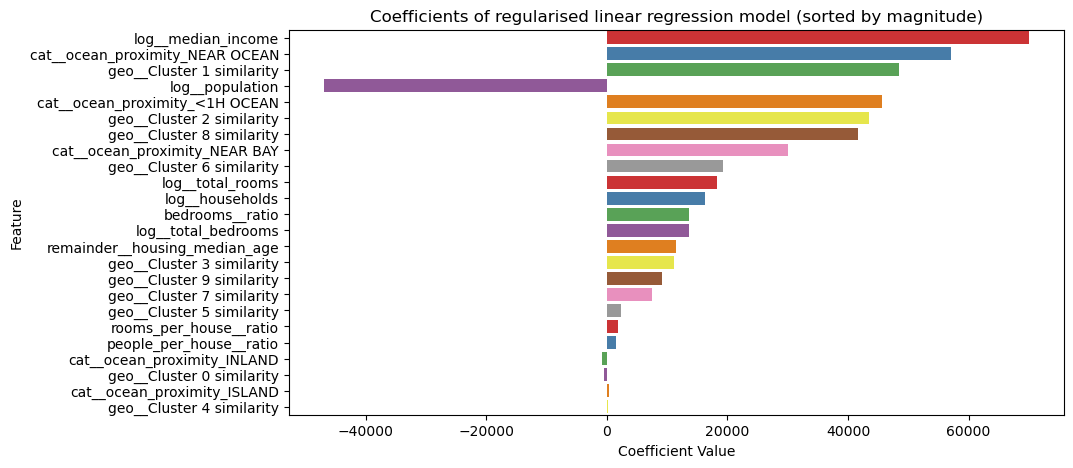

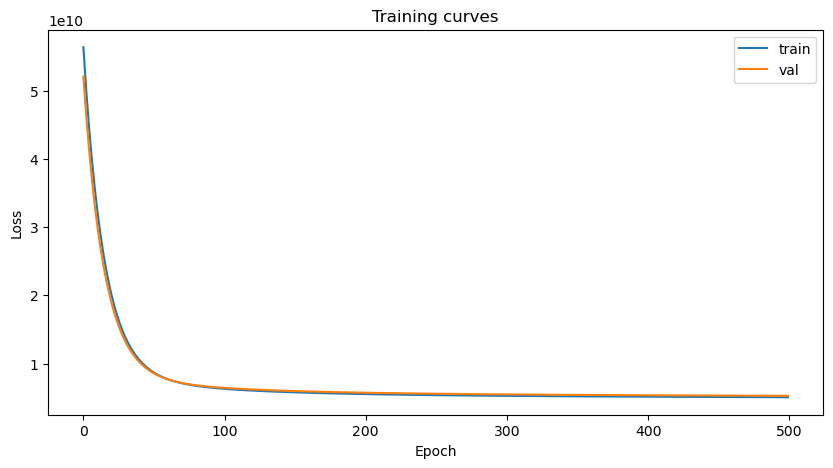

Train loss:  tensor(5.0574e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(5.2686e+09, grad_fn=<SelectBackward0>)
Weight Decay: 0.01
R2: 0.5922081517038003


C:\Users\veron\AppData\Local\Temp\ipykernel_10056\833491417.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


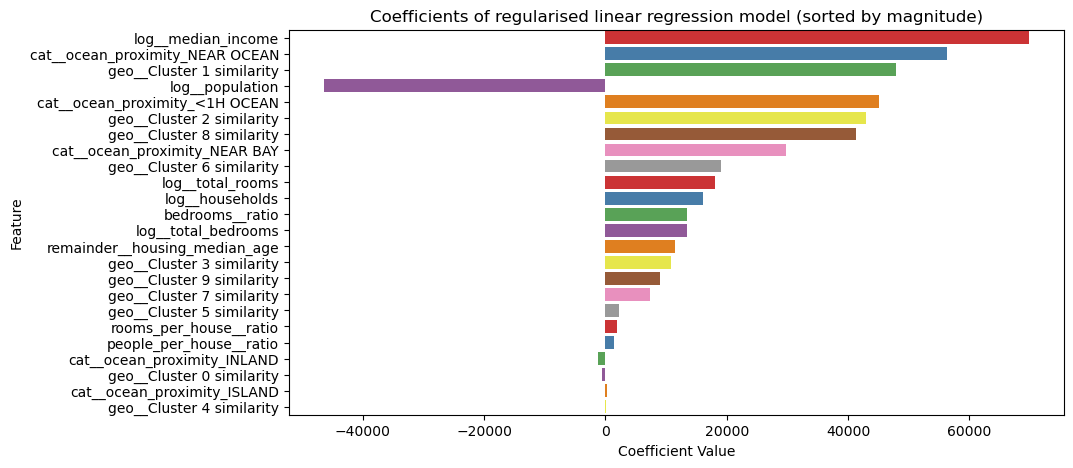

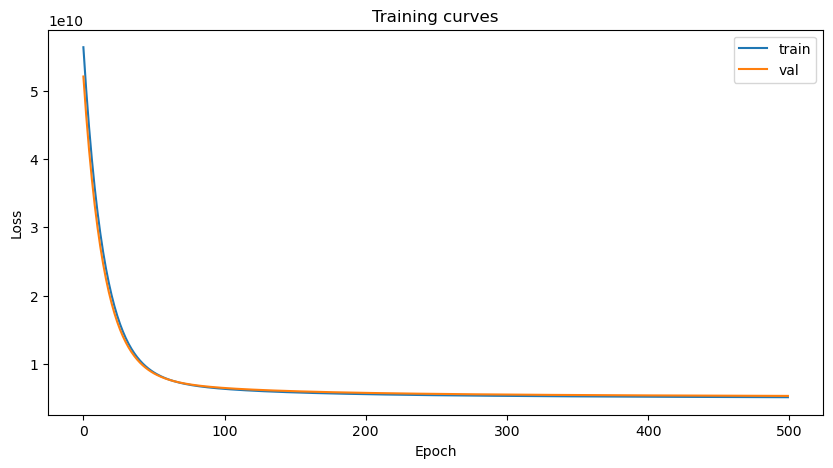

Train loss:  tensor(5.1000e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(5.2933e+09, grad_fn=<SelectBackward0>)
Weight Decay: 0.05
R2: 0.5923156038591373


C:\Users\veron\AppData\Local\Temp\ipykernel_10056\833491417.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


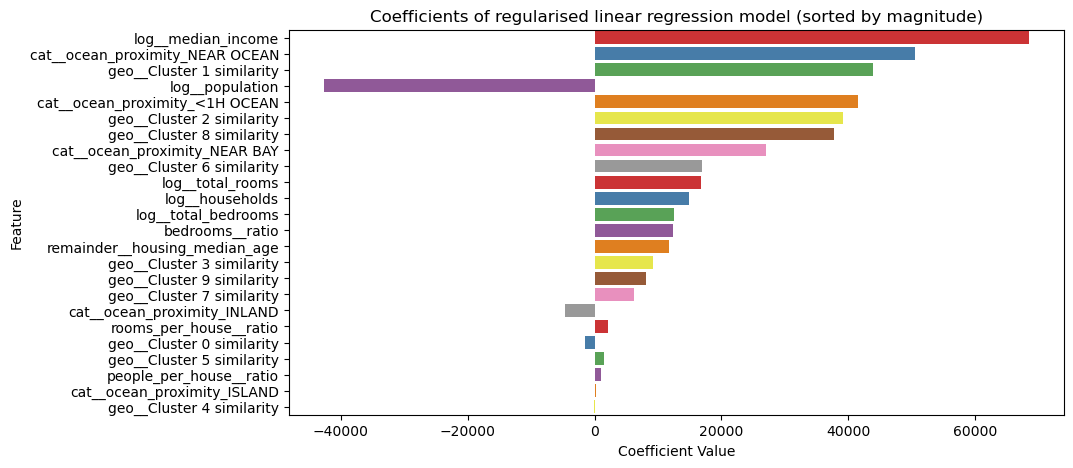

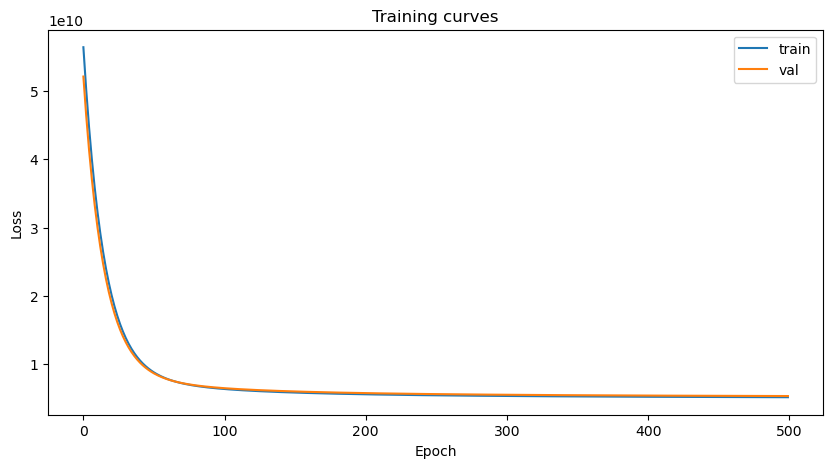

Train loss:  tensor(5.1662e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(5.3388e+09, grad_fn=<SelectBackward0>)
Weight Decay: 0.1
R2: 0.5909168018869209


C:\Users\veron\AppData\Local\Temp\ipykernel_10056\833491417.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


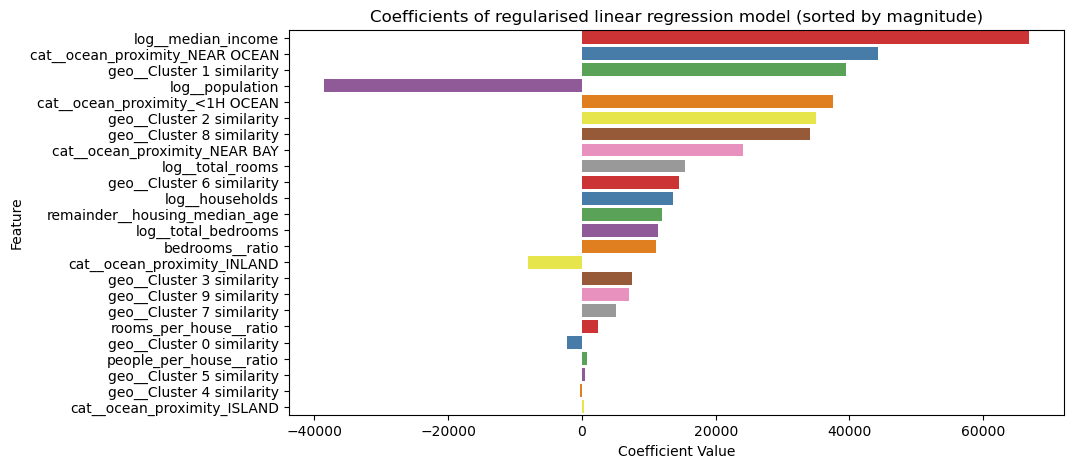

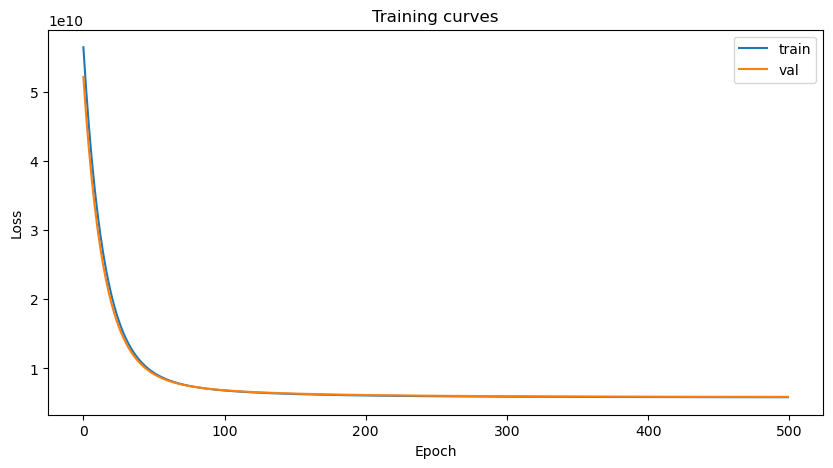

Train loss:  tensor(5.8432e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(5.8969e+09, grad_fn=<SelectBackward0>)
Weight Decay: 0.5
R2: 0.5554180807849627


C:\Users\veron\AppData\Local\Temp\ipykernel_10056\833491417.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


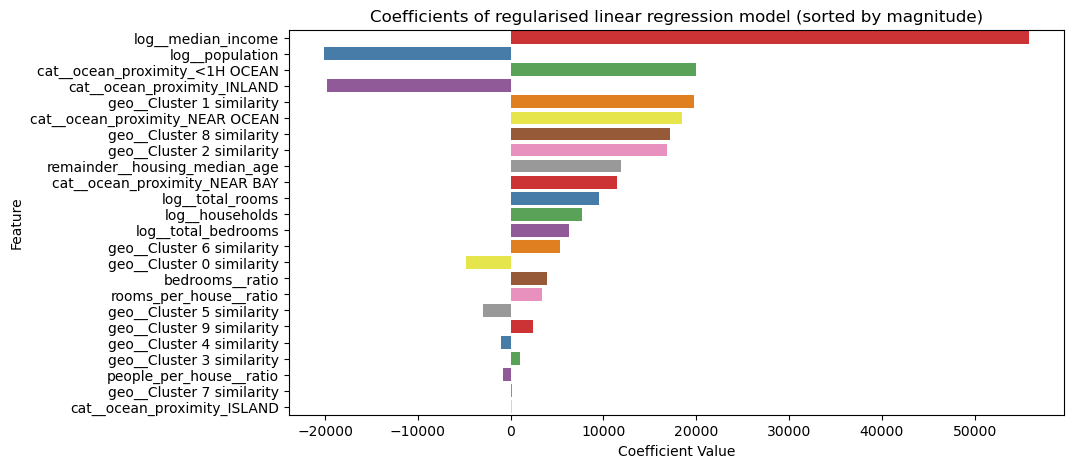

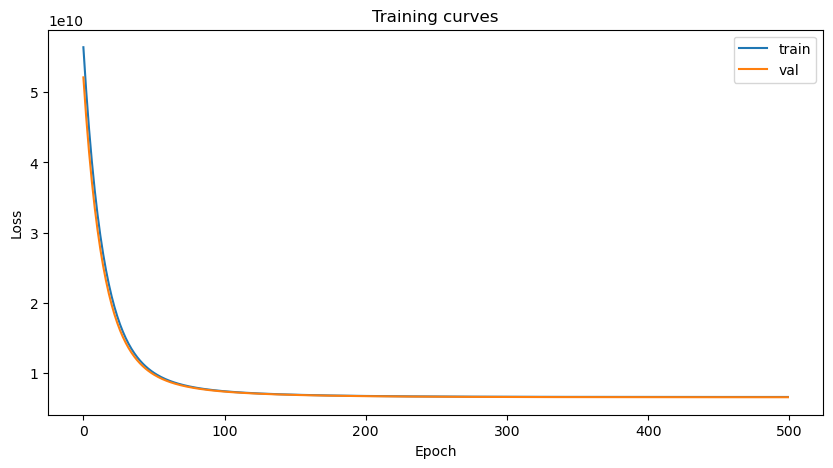

Train loss:  tensor(6.6276e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(6.5926e+09, grad_fn=<SelectBackward0>)
Weight Decay: 1.0
R2: 0.5026953681626725


C:\Users\veron\AppData\Local\Temp\ipykernel_10056\833491417.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


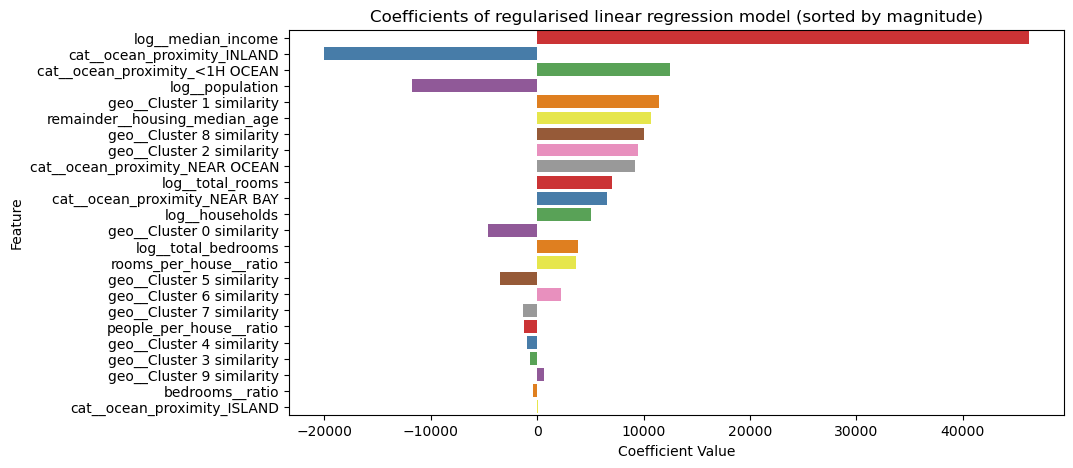

In [255]:
lr = 0.01
num_epochs = 500
wd_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

trained_models = []
r2_list = []

for wd in wd_list:
    l2_model = RegressionModelL2(thousing_X_prep.shape[1],lr=lr,wd=wd)
    l2_model = train_model(thousing_X_prep,thousing_y,l2_model,num_epochs)

    yhat  = l2_model(testX_tensor)

    r2    = r2_score(strat_testy.values, yhat.detach().numpy().reshape(-1))
    print("Weight Decay:", wd)
    print("R2:", r2)
    
    coefs = pd.DataFrame(l2_model.net.weight.data.detach().numpy(), columns=preprocessing.get_feature_names_out())
    sorted_idx = coefs.iloc[0].abs().sort_values(ascending=False).index  # sort by absolute value
    sorted_coefs = coefs[sorted_idx]
    sns.barplot(
    y=sorted_coefs.columns,
    x=sorted_coefs.iloc[0].values, palette='Set1',
    orient='h'
    )
    
    plt.title('Coefficients of regularised linear regression model (sorted by magnitude)')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.show()

In [229]:
# Save model
torch.save(l2_model.state_dict(), 'l2_model.pth')

# Polynomial basis function expansion (5 points)
- use sklearn PolynomialFeatures


In [230]:

# make a PolynomialFeatures constructor (make include_bias = False) for polynomial of degree 2
# make a pipeline involving the basis function function expansion and StandardScaler
# fit and transform thousing_X_prep using that pipeline constructor, call that Xpoly.
# extract the feature names of Xpoly by using the .get_feature_names_out() method for your constructor.
# Finally create a dataframe called Xpoly_df

# START YOUR CODE HERE (5 lines)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_pipe = make_pipeline(poly, StandardScaler())
Xpoly = poly_pipe.fit_transform(thousing_X_prep)
poly_feature_names = poly.get_feature_names_out(thousing_X_prep.columns)
Xpoly_df = pd.DataFrame(Xpoly, columns=poly_feature_names)
# END YOUR CODE HERE

print(Xpoly_df.shape)
Xpoly_df.head()

(16512, 324)


,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,cat__ocean_proximity_ISLAND^2,cat__ocean_proximity_ISLAND cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_ISLAND cat__ocean_proximity_NEAR OCEAN,cat__ocean_proximity_ISLAND remainder__housing_median_age,cat__ocean_proximity_NEAR BAY^2,cat__ocean_proximity_NEAR BAY cat__ocean_proximity_NEAR OCEAN,cat__ocean_proximity_NEAR BAY remainder__housing_median_age,cat__ocean_proximity_NEAR OCEAN^2,cat__ocean_proximity_NEAR OCEAN remainder__housing_median_age,remainder__housing_median_age^2
0,-0.414940,0.259940,-0.071047,-0.309200,-0.176127,-0.694606,-0.397707,1.155572,-0.254794,-0.574154,...,-0.01348,0.0,0.0,-0.010606,-0.35424,0.0,-0.194425,2.587337,-3.235524,0.165409
1,0.295383,-0.077428,-0.029187,0.578894,0.409012,0.364217,0.409001,0.448319,-0.254700,1.173194,...,-0.01348,0.0,0.0,-0.010606,-0.35424,0.0,-0.194425,-0.386498,-0.021038,-0.127047
2,0.193326,-0.372049,-0.068362,2.801941,2.607645,2.567353,2.872884,-1.544561,-0.254792,-0.877970,...,-0.01348,0.0,0.0,-0.010606,-0.35424,0.0,-0.194425,-0.386498,-0.021038,0.690826
3,-0.896236,0.280174,-0.029173,-0.944684,-0.565629,-0.843064,-0.808331,1.975704,-0.254752,0.931395,...,-0.01348,0.0,0.0,-0.010606,-0.35424,0.0,-0.194425,-0.386498,-0.021038,2.600772
4,1.664099,-0.018431,-0.125853,0.885304,0.294025,-0.486523,0.252608,0.938990,-0.254632,1.284195,...,-0.01348,0.0,0.0,-0.010606,-0.35424,0.0,-0.194425,2.587337,-3.235524,0.165409


# Train an L2 model on the basis expanded data in train/val split model. (5 points)


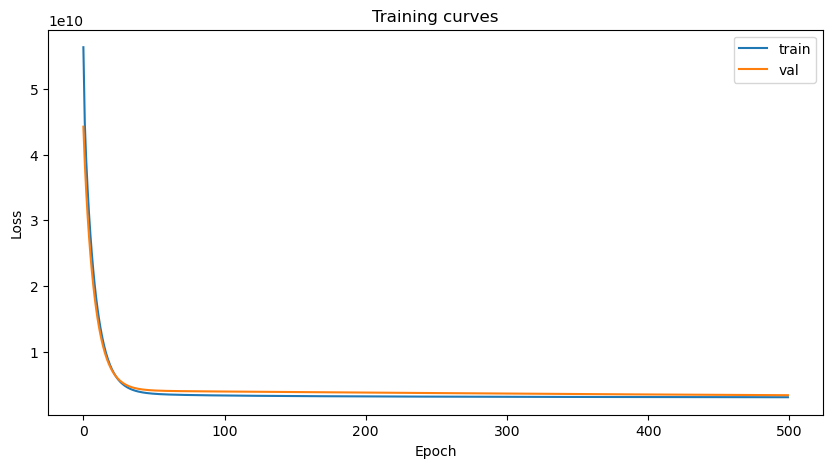

Train loss:  tensor(3.0413e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(3.3501e+09, grad_fn=<SelectBackward0>)


In [231]:
# Set wd to different values and see impact  0.001 - 1
lr = 3e-2
num_epochs = 500
wd = 0.001

l2_model_poly = RegressionModelL2(Xpoly_df.shape[1],lr=lr,wd=wd)
l2_model_poly = train_model(Xpoly_df,thousing_y,l2_model_poly,num_epochs)

# START YOUR CODE HERE (3 lines)
# compute prediction on Xpoly_df (training error)
# compute error using thousing_y, the ground truth
# then calculate training r2
yhat_train = l2_model_poly(make_tensor(Xpoly_df.values))
train_error = make_tensor(thousing_y.values[:, None]) - yhat_train
train_r2 = r2_score(thousing_y.values, yhat_train.detach().numpy().reshape(-1))

# END YOUR CODE HERE

# Evaluate your trained model on the set aside test set (5 points)

In [232]:
# START YOUR CODE HERE (6 lines)
# prepare your set aside test set with preprocessing, followed by the basis function expansion pipeline (3 lines)
# compute prediction of your model on the prepared test dataframe, as well as the error with reference to the ground truth y
# compute r2 based on ground truth y and predicted y and print it
strat_testX = strat_test_set.drop(columns=["median_house_value"])
strat_testX_prep = pd.DataFrame(preprocessing.transform(strat_testX), columns=preprocessing.get_feature_names_out())
X_test_poly = poly_pipe.transform(strat_testX_prep)
testX_poly_tensor = make_tensor(X_test_poly)
yhat = l2_model_poly(testX_poly_tensor)
error = make_tensor(strat_testy.values[:, None]) - yhat
r2 = r2_score(strat_testy.values, yhat.detach().numpy().reshape(-1))
print("R2:", r2)
# END YOUR CODE HERE

R2: 0.6695335830717428


# Run this cell to visualize the predictions

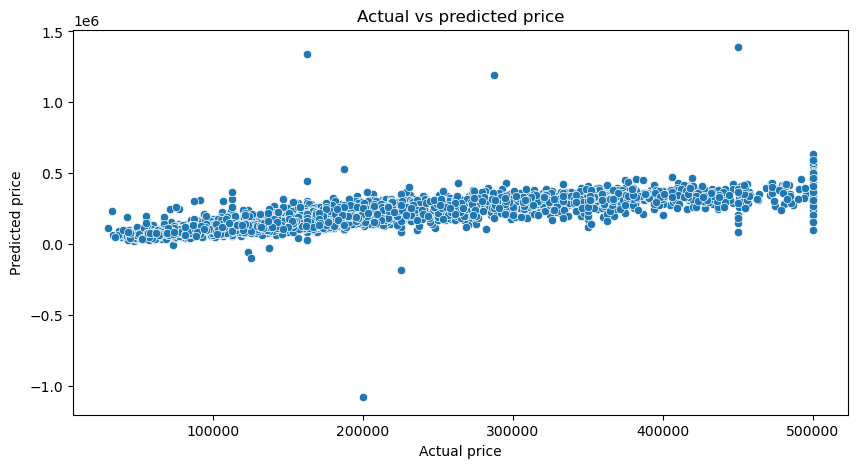

In [233]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=strat_testy_tensor.detach().numpy()[:,0],y=yhat.detach().numpy()[:,0])
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual vs predicted price')
plt.show()

# Experiment with wd and compute training R2 for each choice. (5 points)
Use the basis expanded training data
leave your experiments in the notebook with the plots
complete the code for computing training error and r2

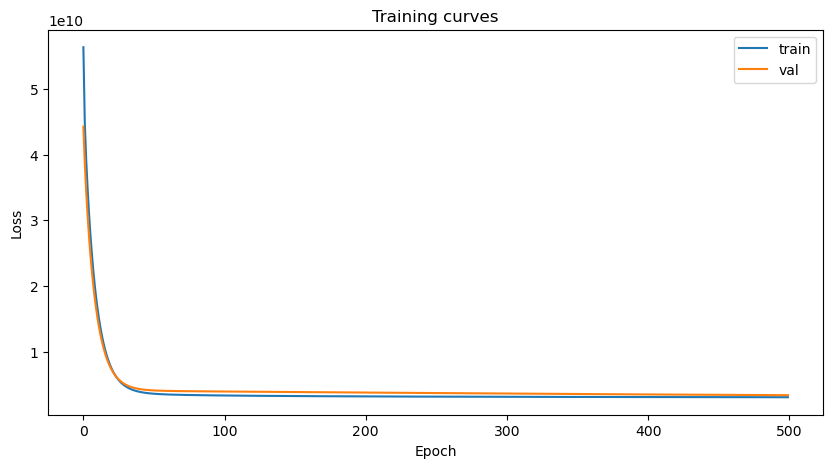

Train loss:  tensor(3.0403e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(3.3516e+09, grad_fn=<SelectBackward0>)


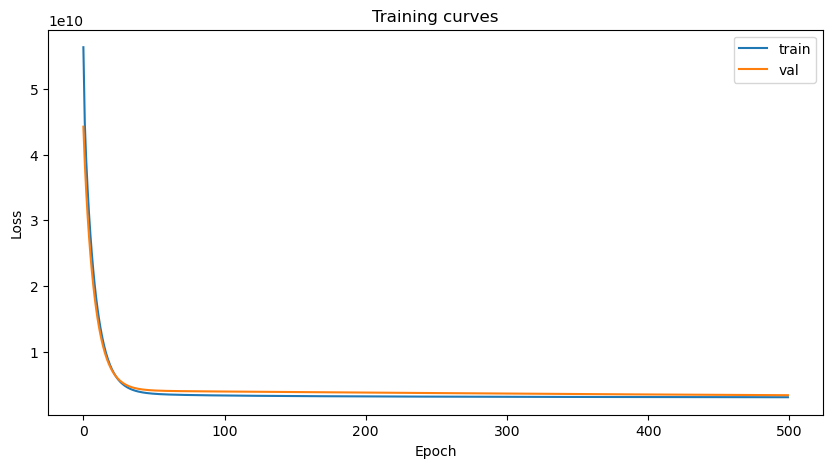

Train loss:  tensor(3.0413e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(3.3501e+09, grad_fn=<SelectBackward0>)


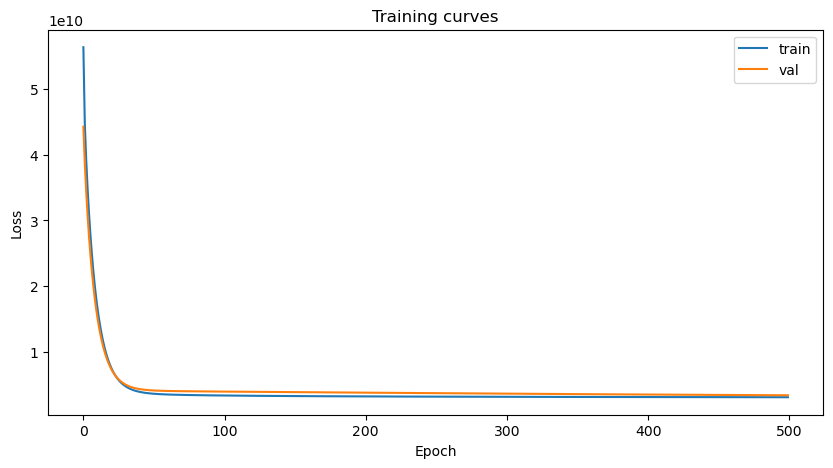

Train loss:  tensor(3.0457e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(3.3440e+09, grad_fn=<SelectBackward0>)


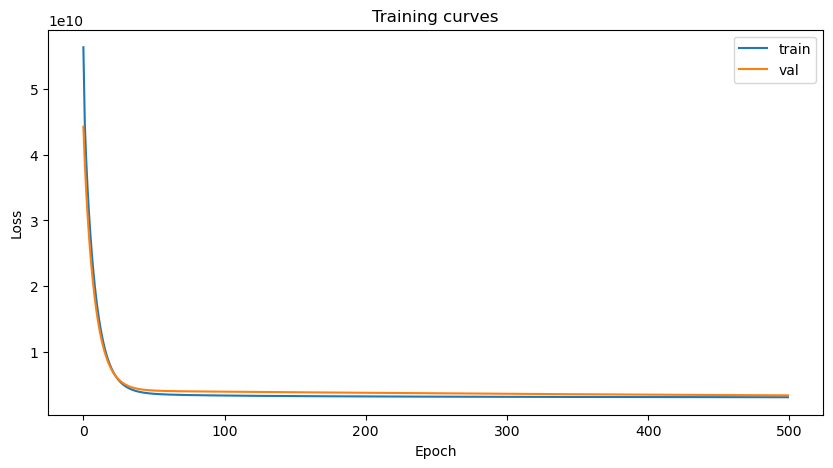

Train loss:  tensor(3.0514e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(3.3380e+09, grad_fn=<SelectBackward0>)


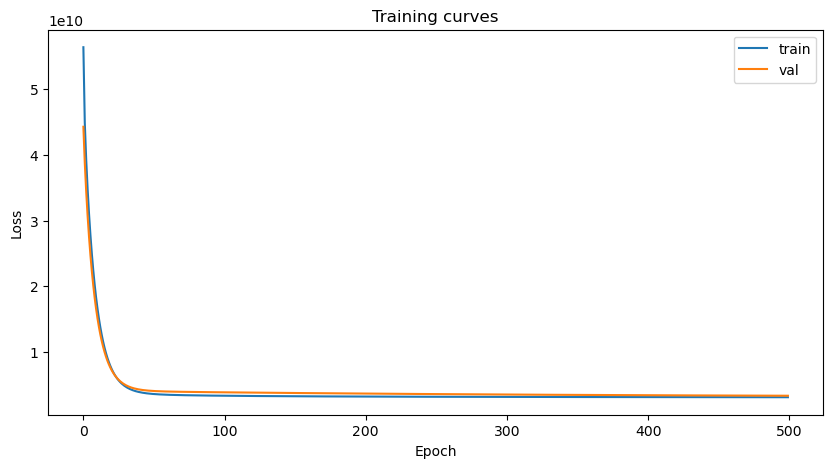

Train loss:  tensor(3.1021e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(3.3296e+09, grad_fn=<SelectBackward0>)


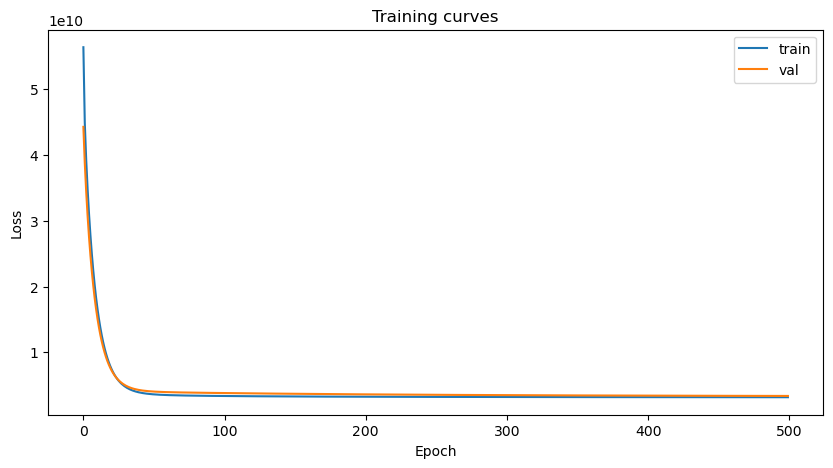

Train loss:  tensor(3.1678e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(3.3628e+09, grad_fn=<SelectBackward0>)


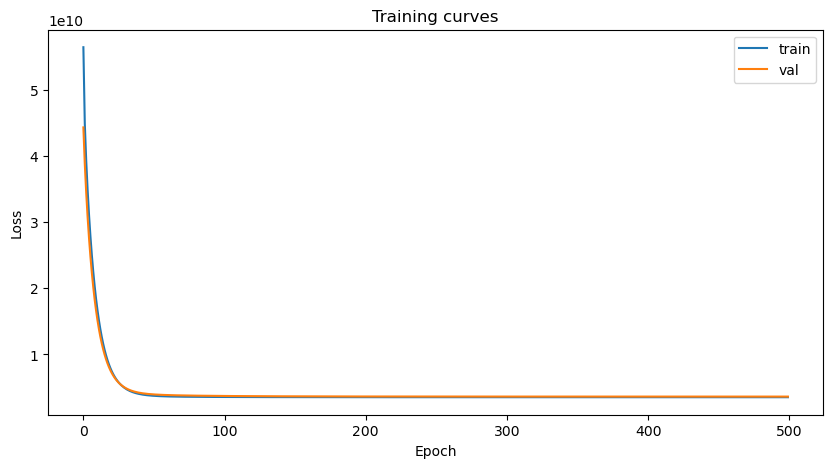

Train loss:  tensor(3.5316e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(3.6272e+09, grad_fn=<SelectBackward0>)


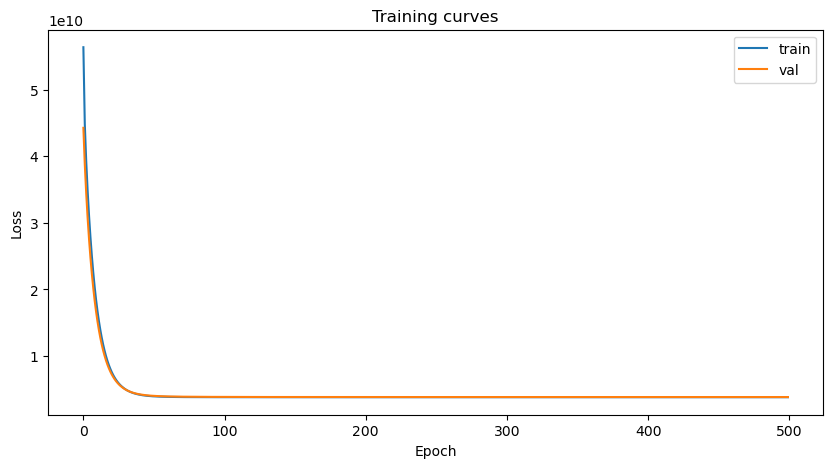

Train loss:  tensor(3.8014e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(3.8276e+09, grad_fn=<SelectBackward0>)
       wd  train_r2     train_mse   test_r2      test_mse
0  0.0001  0.767465  3.102441e+09  0.668690  4.376587e+09
1  0.0010  0.767430  3.102909e+09  0.669534  4.365447e+09
2  0.0050  0.767257  3.105216e+09  0.673081  4.318584e+09
3  0.0100  0.767005  3.108577e+09  0.677091  4.265621e+09
4  0.0500  0.764090  3.147467e+09  0.697336  3.998185e+09
5  0.1000  0.759647  3.206747e+09  0.707442  3.864682e+09
6  0.5000  0.733866  3.550716e+09  0.707349  3.865908e+09
7  1.0000  0.714684  3.806646e+09  0.694121  4.040655e+09


In [263]:
# YOUR CODE for training with different wd
lr = 3e-2
num_epochs = 500
wd_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

train_r2_list  = []
train_mse_list = []
test_r2_list  = []
test_mse_list = []

strat_testX_prep = pd.DataFrame(
    preprocessing.transform(strat_testX),
    columns=preprocessing.get_feature_names_out(),
    index=strat_testX.index
)
X_test_poly = poly_pipe.transform(strat_testX_prep)
testX_poly_tensor = make_tensor(X_test_poly)
y_test_np = strat_testy.values
y_train_np = thousing_y.values

for wd in wd_list:
    model = RegressionModelL2(Xpoly_df.shape[1], lr=lr, wd=wd)
    model = train_model(Xpoly_df, thousing_y, model, num_epochs)

    yhat_train = model(make_tensor(Xpoly_df.values))                  
    yhat_train_np = yhat_train.detach().cpu().numpy().ravel()         
    train_r2  = r2_score(y_train_np, yhat_train_np)
    train_mse = mean_squared_error(y_train_np, yhat_train_np)
    train_r2_list.append(train_r2)
    train_mse_list.append(train_mse)

    yhat_test = model(testX_poly_tensor)                              
    yhat_test_np = yhat_test.detach().cpu().numpy().ravel()           
    test_r2  = r2_score(y_test_np, yhat_test_np)
    test_mse = mean_squared_error(y_test_np, yhat_test_np)
    test_r2_list.append(test_r2)
    test_mse_list.append(test_mse)

results_df = pd.DataFrame({
    "wd": wd_list,
    "train_r2": train_r2_list,
    "train_mse": train_mse_list,
    "test_r2": test_r2_list,
    "test_mse": test_mse_list,
})

print(results_df)


# Hyperparameter sweep (15 points)

- we gave you some good starting hyperparameters for learning rate, weight decay and number of geographic clusters for preprocessing. Now we do a systematic sweep across a set of possible hyperparameter values to determine the best setting for them.
- complete the code below to do a simple for-loop based parameter sweep (it is a nested loop of three fors -- outer one goes over the cluster number, the inner ones loop over learning rate and weight decay). For each setting train the models in CV mode (train_cv_model) on your training data, and get the r2 scores on the validation sets for each fold. Select the hyperparameter combo that gives you the highest mean r2 score.

In [236]:
best_params

{'n_clusters': 12, 'lr': 0.01, 'wd': 0.0001}

# Construct a new model with these hyperparameters (5 points)
- train this model on the preprocessed, and basis expanded, training set
- evaluate its performance on the set aside test set (suitably preprocessed and basis expanded) and print r2

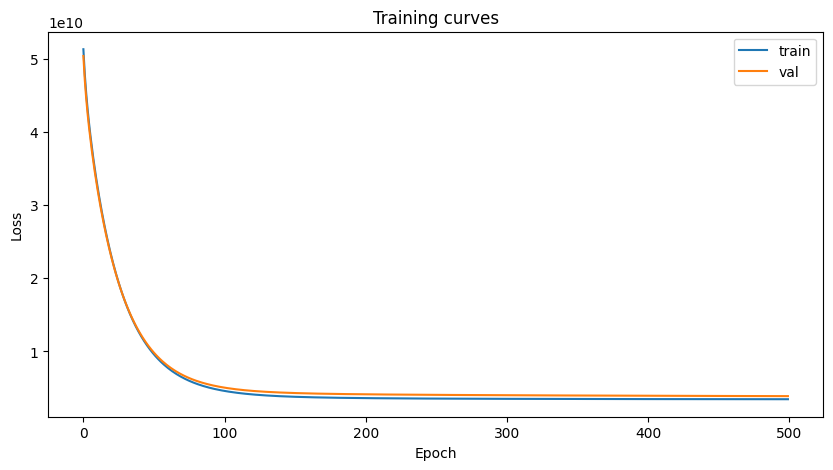

Train loss:  tensor(3.4674e+09, grad_fn=<SelectBackward0>)
Val loss:  tensor(3.8897e+09, grad_fn=<SelectBackward0>)
train R2 =  0.748324427090743


In [67]:
lr = best_params['lr']
wd = best_params['wd']
num_epochs = 500
preprocessing.set_params(geo__n_clusters=best_params['n_clusters'])

# START YOUR CODE HERE 
# run the preprocessing pipeline with the best cluster number (set for you above)
# then do the basis function piepline to get Xpoly_df as before (7 lines)


# initialize the L2 model with the best lr and best wd (1 line)



# train the model using the simple train_model function (1 line)


# compute the prediction on the training set itself, and the error (2 lines)

# assess model quality using r2  on training set (1 line)


# END YOUR CODE HERE

# Evaluate performance of fine tuned model on the set aside test set (5 points)

test R2 =  0.6953990459442139


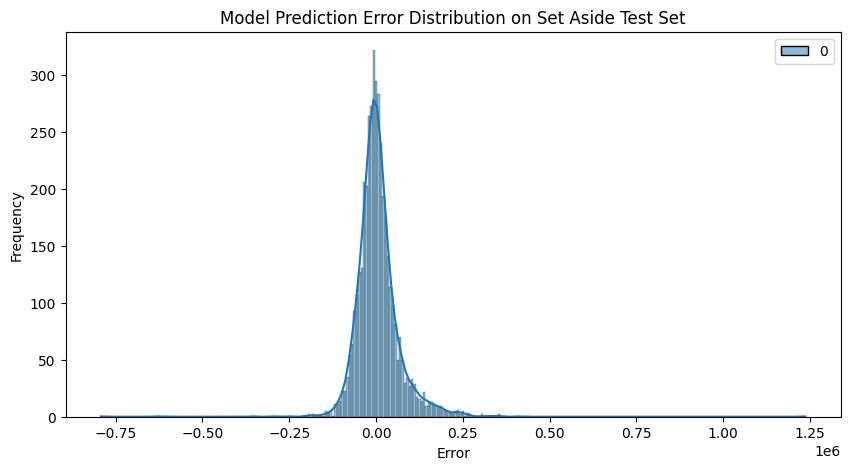

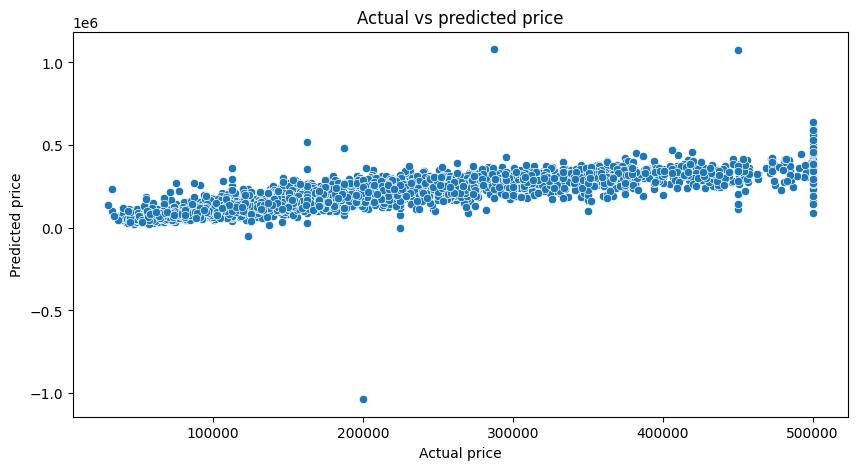

In [68]:
# START YOUR CODE HERE

# preprocess the set aside dataset with the best preprocessing and basis function pipelines (3 lines)
# compute prediction on test set and error, as well as r2 score (3 lines)


# END YOUR CODE HERE

# adjust variable names below to be consistent with your variable names.
plt.figure(figsize=(10,5))
sns.histplot(error.detach().numpy(),kde=True)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Model Prediction Error Distribution on Set Aside Test Set')
plt.show()

plt.figure(figsize=(10,5))
sns.scatterplot(x=strat_testy_tensor.detach().numpy()[:,0],y=yhat.detach().numpy()[:,0])
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual vs predicted price')
plt.show()

# Congratulations! 
- You have built unregularized and L2 regularized models in PyTorch.
- Please leave all code and plots in this notebook and upload it onto Gradescope.
 